# Simulation and Monte Carlo Project 

# Control variates for a GARCH model

### Sommaire 

**Introduction :** Presentation of the research paper and objectives

**I)** Implementation of a random walk Metropolis sampler (MCMC) that targets the posterior distribution of a GARCH model *(Question 1)*

**II)** Linear regression to compute the optimal coefficients of the control variates to reduce the variance of the first model in the 1st degree polynomial case *(Question 2)*

**III)** Implementation of a method based on Lasso regression in the case of a high degree polynomial (large set if control variates) and comparison with the naive approach *(Question 3)*

**IV)** Validity of linear regressions when applied to a MCMC sample and ways to adress this issue *(Bonus question)*

**Conclusion** 

### Import des modules utiles  

In [1]:
!pip3 install pandas_datareader
!pip3 install arch

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import statistics
import pandas_datareader as pdr
import seaborn as sns
import random

import arch 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import MultiTaskLassoCV

### Introduction : Presentation of the research papers and objectives

#### **1) 1st research paper** : *Zero variance Markov chain Monte Carlo for Bayesian estimators*

This first article is the main article of the project.

Starting from the general idea that Markov chain Monte Carlo (MCMC) methods can be used to estimate integrals using a large but finite set of points, this paper suggests a general method to reduce the MCMC error by replacing $f$ with a different function, $\tilde{f}(x)$, obtained by properly re-normalizing f .

Indeed, we need to evaluate the expected value of a function $f$ with respect to a, possibly unnormalized, probability distribution $π$, which can be written : $$\mu_f = \frac{\int f(x) \pi(x) dx}{\int \pi(x) dx}$$ 
In order to compute it, we can use MCMC methods to estimate this integral with a large but finite sample $x_i$, $i = 1, \dots, N$, collected along the sample path of an ergodic Markov chain having π (normalized) as its unique stationary and limiting distribution : $$\hat{\mu}_f = \frac{1}{N} \sum_{i=1}^{N} f(x_i)$$


**This article explains the zero-variance (ZV) principle: an almost automatic method to construct control variates for MC simulation, in which an operator, $H$, acting as a map from functions to functions, and a trial function, $ψ$, are introduced under conditions and properties.**

These 2 functions are used to create the new re-normalized function defined as : $$\tilde{f}(x) = f(x) + \frac{Hψ(x)}{\sqrt{\pi(x)}}$$ which satisfies : $\mu_f = \mu_{\tilde{f}}$. 

**Therefore, this function is supposed to lead to the same expected value, while allowing to reduce the variance of the MCMC estimator**, and it is all the objective of this paper to present how to implement this function and to illustrate it through some real applications to probit, logit and GARCH Bayesian models. **We will, in this project, focus on an example based on the GARCH Bayesian models.**

Finally, in this paper, conditions for asymptotic unbiasedness of the zero-variance estimator are derived, and a central limit theorem is also proved under regularity conditions, but these demonstrations are not the main point of our project.  

#### **2) 2nd research paper** : *Control variate selection for Monte Carlo integration*

This article shows how Monte Carlo integration with variance reduction by means of control variates can be implemented by the ordinary least squares estimator. 

Indeed, by using control variates as covariates and $f(x)$ as the explained variable, we can find the optimal coefficients of the control variates and, therefore, we can use them in $\tilde{f}(x)$ of the 1st paper for instance in order to estimate parameters and to reduce the variance of the estimator. 

Indeed, in the 1st article for instance, for the 1st order polynomial case **(which will be discussed in II°(Question 2))**, $\tilde{f}(x)$ can be written : $f(x) + a^T z$ where z is the vector of covariates, and a are the coefficients computed by an OLS regression of $f(x)$ on $-z$. 

This article also presents some Lasso methods (LSLasso and LSLasso(X) especially) in order to deal with the high degree polynomial case for instance, because it allows to reduce the computation time by keeping only the most useful control variates and then to apply OLS regressions only with these control variates keeped. Indeed, the paper explains this by saying that : "Incorporating a large number of control variates in the ordinary least squares procedure may however result in (i) a certain instability of the ordinary least squares estimator and (ii) a possibly prohibitive computation time. Regularizing the ordinary least squares estimator by preselecting appropriate control variates via the Lasso turns out to increase the accuracy without additional computational cost.". 

**We will present the Lasso methods in III° (Question 3).** 

### **I)** Implementation of a random walk Metropolis sampler (MCMC) that targets the posterior distribution of a GARCH model *(Question 1)*

**Markov chain Monte Carlo**

In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain (stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event) that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps that are included, the more closely the distribution of the sample matches the actual desired distribution.

**Metropolis Hastings: presentation**

In statistics and statistical physics, the Metropolis–Hastings algorithm is a Markov chain Monte Carlo (MCMC) method for obtaining a sequence of random samples from a probability distribution from which direct sampling is difficult. This sequence can be used to approximate the distribution (e.g. to generate a histogram) or to compute an integral (e.g. an expected value).

More formally, given a probability distribution $\pi$ on a universe $\Omega$ , this algorithm defines a Markov chain whose stationary distribution is $\pi$ . It thus makes it possible to draw randomly an element of $\Omega$ according to the law $\pi$.

A key point of the Metropolis-Hastings algorithm is that it requires only the knowledge of $\pi$ to within one multiplicative constant. In particular, it is not necessary to compute the partition function of $\pi$ which is often a difficult task. For this reason, this method is widely used in statistical physics.

**Metropolis Hastings algorithm**

We saw, in *Introduction to Stochastic Process* and *Simulation and Monte Carlo* courses, how Metropolis Hastings algorithm works and why we use it. 

Indeed, suppose that we wish to calculate an expectation: we give ourselves a law $π$ on $E$, a function $f$, and we wish to approach numerically $$\mathbb{E}_{X \sim \pi}[f] = \int_E f(x) \pi(x) dx$$ (if of course this quantity exists). For this, one could simulate variables $X_i$ i.i.d of law $π$ and use the law of large numbers: $$\frac{1}{n}\sum_{i=1}^n X_i \xrightarrow{p.s.}\int_E f(x) \pi(x) dx$$

The problem is that if $π$ is twisted, it can be very expensive to simulate variables of law $π$. One idea is to simulate a positive recursive irreducible Markov chain (Xn) of limit law $π$. **Then the above convergence will still hold according to the following theorem:**

**Let $(X_n)$ a positive recursive irreducible Markov chain of limit law $π$, of transition matrix $P$ and of initial law $\mu$. Then, for all functions $f$ such that $\int |f| d\pi < \infty$, we have:
$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f d\pi \quad \text{almost surely when } n \to \infty$**

The Metropolis Algorithm, and one of its generalisations, Metropolis-Hastings, allow to simulate a Markov chain of P π-reversible transition, and thus, of invariant law π. Note that it remains to verify that the chain is irreducible (if it is, as it admits an invariant probability, it is positively recurrent).

**Metropolis algorithm is written as follows:** 

Let $E = \mathbb{Z}^d$ for $d \geq 1$. Let $q$  be a probability measure such that we can simulate a random variable of distribution $q$. It is assumed that $q$ is symmetric. Let $X_0$ fixed. Given $X_n$:

1. On tire $Z_n \sim q$ (indépendante de toutes les variables simulées jusqu’ici)
2. On tire $U_n \sim \mathcal{U}([0,1])$ (idem)
3. On définit : \[
\begin{cases}
X_{n+1} = X_n + Z_n \text{ si } U_n \leq \min\left(1, \frac{\pi(X_n+Z_n)}{\pi(X_n)}\right) \\
X_{n+1} = X_n \text{ sinon}.
\end{cases}
\]

*Remark : $\pi$ only appears in the ratio $\frac{\pi(X_n+Z_n)}{\pi(X_n)}$. So, if we only know $\pi$ to within one multiplicative factor, we can still use the algorithm!*

**Implementation of the Metropolis sampler in our example of a GARCH Bayesian model**

In econometrics, the autoregressive conditional heteroskedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.

ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering, i.e. periods of swings interspersed with periods of relative calm.

The GARCH (p, q) model includes $p$ autoregressive terms for the past values of the conditional variance $\sigma_t^2$, and $q$ moving average terms for the past squared error terms $\epsilon_t^2$. The parameter $\omega$ is the constant term, $\alpha_i$ are the coefficients of the lagged error terms, and $\beta_i$ are the coefficients of the lagged conditional variances.

$y_t = x'_t b + \epsilon_t \$

${\displaystyle \epsilon _{t}|\psi _{t-1}\sim {\mathcal {N}}(0,\sigma _{t}^{2})}$

$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_q \epsilon_{t-q}^2 + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_p \sigma_{t-p}^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^p \beta_i \sigma_{t-i}^2$


**In our example presented in the 1st paper, we have a Normal-GARCH(1,1) model, that is to say we assume that the returns are conditionnaly normally distributed:** $r(t)|F_t \sim \mathcal{N}(0,h_t)$, where $h_t$ is a predictable ($F_{t-1}$-measurable) process: $h_t = \omega_1 + \omega_3 h_{t-1} + \omega_2 r_{t-1}^2$, where $\omega_1 > 0$, $\omega_2 \geq 0$, and $\omega_3 \geq 0$.

**Therefore, compared to the general example above, $h_t = \sigma_t^2$, $r_t = \epsilon_{t}^2$, and $p=1$, $q=1$ so $\omega = \omega_1$, $\alpha_1 = \omega_2$ et $\beta_1 = \omega_3$**

**Our goal is to estimate the expected value of $\omega_j$ under the posterior $\pi$, using independent truncated normal priors.**

Indeed, we are in a Bayesian model, where Bayesian statistics is a theory in the field of statistics based on the Bayesian interpretation of probability where probability expresses a degree of belief in an event. It differs from other statistics' theory like the frequentist interpretation that views probability as the limit of the relative frequency of an event after many trials. 

The degree of belief may be based on prior knowledge about the event, such as the results of previous experiments, or on personal beliefs about the event. **In our example, the paper tells us that we have independant truncated normal priors because $\omega_1 > 0$, $\omega_2 \geq 0$ and $\omega_3 \geq 0$, so that means that it is our prior knowledge about the event.**

**Therefore, as we know that the truncated density for the normal distribution is $f(x|\mu,\sigma,a) = \begin{cases} \frac{1}{Z} \phi\left(\frac{x-\mu}{\sigma}\right) & \text{ if } x \geq a \ \text{ and} & \text{ } 0 & \text{ if } x < a \end{cases}$, where $\phi$ is the probability density function of the standard normal distribution and $Z$ is a normalisation constant, we can conclude that for $\omega_1$, we are going to simulate them with this probability density function  $\phi(x) = \begin{cases}\frac{2}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} & \text{ if } x > 0 \ & \text{ and} & \text{ } 0 & \text{ if } x \leq 0 \end{cases}$, and we are going to use $\phi(x) = \begin{cases}\frac{2}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}} & \text{ if } x \geq 0 \ & \text{ and} & \text{ } 0 & \text{if } x < 0 \end{cases}$ for $\omega_2$ and $\omega_3$.**

Moreover, Bayesian statistics are based on Bayes' theorem which is used in Bayesian methods to update probabilities. The Bayes' theorem states that :  Given two events $A$ and $B$, the conditional probability of $A$ given that $B$ is true is expressed as follows: $P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}$. $\displaystyle P(A)$ is the prior probability of $A$ which expresses one's beliefs about $A$ before evidence is taken into account. The prior probability may also quantify prior knowledge or information about $A$. $\displaystyle P(B\mid A)$ is the likelihood function, which can be interpreted as the probability of the evidence $B$ given that $A$ is true. The likelihood quantifies the extent to which the evidence $B$ supports the proposition $A$. $\displaystyle P(A\mid B)$ is the posterior probability, the probability of the proposition $A$ after taking the evidence $B$ into account. Essentially, Bayes' theorem updates one's prior beliefs $P(A)$ after considering the new evidence $B$. The posterior is proportional to this product: $P(A \mid B) \propto P(B \mid A) P(A)$.

**We have the priors density probability functions, and we know that they are independent, so**

$$prior = P(\omega_1,\omega_2,\omega_3) = P(\omega_1) * P(\omega_1) * P(\omega_3)$$

**Now that we have our prior, in order to calculate our posterior, we need to calculate the likelihood of our Normal-GARCH(1,1) model since we know that:** 

$$posterior ∝ likelihood * prior$$

**We know that $r(t)|F_t \sim \mathcal{N}(0,h_t)$, so by multiplying these normal density probability functions of a Normal distribution centered in 0 and of variance $h_t$, it leads to the likelihood :** 

$$ l(\omega_1, \omega_2, \omega_3|r) \propto {(\prod_{t=1}^T h_t)}^{-\frac{1}{2}} \exp \left(-\frac{r_t^2}{2h_t}\right)$$

**and to the loglikelihood (easier to compute the loglikelihood for the next steps) of our GARCH Model:**

$$ln L(\omega_1, \omega_2, \omega_3|r) = -0.5 * (T * \ln(2π) + \sum_{i=1}^{T}(\ln(h_t)) + \sum_{i=1}^{T}(r_t^2 / h_t))$$

This will lead to this formula for the posterior function $\pi$: 

$$\pi(\omega_1,\omega_2,\omega_3|r) \propto \exp{(-0.5(\frac{\sigma^2(\omega_1)}{\omega_1^2} + \frac{\sigma^2(\omega_2)}{\omega_2^2} + \frac{\sigma^2(\omega_3)}{\omega_1^3})){(\prod_{t=1}^T h_t)}^{-\frac{1}{2}} \exp \left(-\frac{r_t^2}{2h_t}\right)}$$


**Implementation of a random walk Metropolis sampler (MCMC) on simulated data**

**Explication du code**

Therefore, we are going to code all this theory explained above. 

The function *simulate_garch(omega, T)* takes omega, a vector of 3 components $\omega_1$, $\omega_2$ and $\omega_3$, and T, the length of time of the returns, as parameters. We first initialize our $h_0$ with a usual parameter found in the literature of GARCH(1,1) which is $\frac{\omega_1}{1-\omega_2-\omega_3}$. We also initialize the first return with a normal centered in 0 and of variance $h_0$, since returns are normally distributed as seen previously in the formula. We then compute, for every time t in [1,T], the new variance $h_t$ with the formula seen before and the corresponding returns with this variance $h_t$. We return an array with all the returns and a list with all the $h_t$.

In [3]:
def simulate_garch(omega, T):
    h0 = omega[0]/(1 - omega[1] - omega[2])
    std_h = [np.sqrt(h0)]
    returns = [norm.rvs(loc = 0, scale = np.sqrt(h0))]
    for i in range(1,T):
        #formula of h_i defined in the GARCH(1,1)
        h_i = omega[0] + omega[1]* returns[i-1]**2 + omega[2]* std_h[i-1]**2
        std_h.append(np.sqrt(h_i))
        #the returns are normally distributed with a lmean of 0 and a variance of h_i
        returns.append(norm.rvs(loc = 0, scale = np.sqrt(h_i)))
    return np.asarray(returns), std_h 

The function *garch_loglikelihood(omega, returns)* computes the loglikelihood of the model garch as described in the previous paragraphs, which will be used to compute the posterior distribution which is our target. 

The function *prior(omega, std_prior)* computes the prior distributions described in the previous paragraphs. These priors are independant truncated normal distributions, and therefore we can multiply the 3 priors to have the prior of $[\omega_1,\omega_2,\omega_3]$ as explained earlier.

The function *proposal(omega,std_proposal)* corresponds to the $X_n + Z_n$ described in the Metropolis algorithm which follows a standard normal distribution centered in $\omega_i$ and with a constant standard deviation proposal. 

Finally, the function *metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)* is the implementation of the algorithm presented earlier where we create our positive recursive irreducible Markov chain of limit law $π$. It returns the acceptance rate of our algorithm as well as our chain, which is a list (of length: iterations) of vectors with length 3 corresponding to $[\omega_1,\omega_2,\omega_3]$. 

In this last algorithm, garch_loglikelihood(omega_star, returns) + $\ln(\text{prior(omega_star,std_prior}))$ is equal to $\ln(\text{posterior(Xn+Zn)})$ because *omega_star* corresponds to *Xn+Zn* and we have therefore: 
$\ln(\text{likelihood(Xn+Zn)*prior(Xn+Zn)}))$ = $\ln(\text{posterior(Xn+Zn)}))$

We also have garch_loglikelihood(omega, returns) + $\ln(\text{prior(omega,std_prior}))$is equal to $\ln(\text{posterior(Xn+Zn)})$ because omega corresponds to Xn and we have therefore $\ln(\text{likelihood(Xn)*prior(Xn)}))$ = $\ln(\text{posterior(Xn)}))$

Therefore, garch_loglikelihood(omega_star, returns) - garch_loglikelihood(omega, returns) + np.log(prior(omega_star,std_prior)) - np.log(prior(omega,std_prior)) = $\ln(\text{posterior(Xn+Zn)})$ - $\ln(\text{posterior(Xn)})$ = $\ln(\frac{\text{posterior(Xn+Zn)}}{\text{posterior(Xn)}})$

We had to put everything to log in order to avoid mistakes that happened and that created a chain with values of omega negative. 

In [4]:
# We define epsilon in order to compute later the truncated prior of w1 which is strictly positive
epsilon = 1e-12

# Define the GARCH model
def garch_loglikelihood(omega, returns):
    w1 = omega[0]
    w2 = omega[1]
    w3 = omega[2]
    T = len(returns)
    var_h = np.zeros(T)
    var_h[0] = np.var(returns)
    for i in range(1, T):
        var_h[i] = w1 + w2*returns[i-1]**2 + w3*var_h[i-1]
    loglikelihood = -0.5*T*np.log(2*np.pi) - 0.5*np.sum(np.log(var_h)) - 0.5*np.sum(returns**2/var_h)
    return loglikelihood

# Define the prior distributions
def prior(omega, std_prior):
    #truncated (between 0 and 10 so positively)normal prior centered in the previous w1 and with a constant standard deviation prior
    w1_prior = truncnorm.pdf(omega[0], a = 0 , b = 10, loc=0, scale=std_prior)
    #truncated normal prior centered in the previous w2 and with a constant std_prior
    w2_prior = truncnorm.pdf(omega[1], a = 0, b = 10,loc=0, scale=std_prior)
    w3_prior = truncnorm.pdf(omega[2],a = 0, b = 10, loc=0, scale=std_prior)
    return w1_prior * w2_prior * w3_prior

# Define the proposal distribution
def proposal(omega,std_proposal):
    w1_proposal = norm.rvs(loc=omega[0], scale=std_proposal)
    w2_proposal = norm.rvs(loc=omega[1], scale=std_proposal)
    w3_proposal = norm.rvs(loc=omega[2], scale=std_proposal)
    return np.array([w1_proposal, w2_proposal, w3_proposal])

# Define the Metropolis-Hastings sampler
def metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal):
    # We initialize our vector omega of length 3 which is coded as a list here
    omega = initial_omega
    # We initialize our chain 
    omega_samplers = [initial_omega]
    accepted = np.zeros(iterations)
    # We do the 3 steps-process described in the previous paragraphs
    for i in range(iterations):
        # We compute X_n + Z_n with the function proposal 
        omega_star = proposal(omega, std_proposal)
        # We compute the probability of acceptation : the only difference with the algorith presented is the fact that we have put everything to log 
        # Alpha is equal to log(posterior(Xn + Zn)/posterior(X_n))
        alpha = garch_loglikelihood(omega_star, returns) - garch_loglikelihood(omega, returns) + np.log(prior(omega_star,std_prior)) - np.log(prior(omega,std_prior))
        # The following is the quivalent of checking if U_n unifromly distributed
        # between 0 and 1 is inferior or not to the minimum between 1 and 
        # the fraction posterior(Xn+Zn)/posterior(Xn)
        # However, we put everything to log to avoid errors in computation
        if 0 < alpha:
            omega = omega_star
            # We put 1 when we accept the new value to later compute the acceptance rate of the algorithm
            accepted[i] = 1
        else:
            u = np.random.uniform()
            if np.log(u) < alpha: 
                omega = omega_star
                accepted[i] = 0
        omega_samplers.append(omega)
    acceptance_rate = np.sum(accepted)/len(accepted)*100
    return omega_samplers, acceptance_rate

**Example on simulated data** 

In [5]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 5000
burn_in = 1000

std_prior = 10
std_proposal = 0.01

Text(0, 0.5, 'omega')

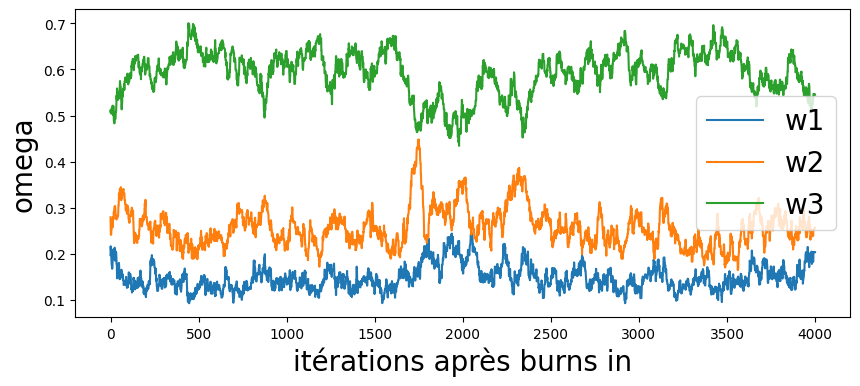

In [6]:
# We execute our algorithm to get our Markov Chain
liste = metropolis_hastings(initial_omega, returns, iterations, std_prior, std_proposal)

# We separate the 3 lists corresponding to the 3 parameters
w1_samples = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
w2_samples = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
w3_samples = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]

# We plot the different trajectories 
plt.figure(figsize=(10,4))
plt.plot(w1_samples[burn_in:])
plt.plot(w2_samples[burn_in:])
plt.plot(w3_samples[burn_in:])
plt.legend(['w1','w2','w3'], fontsize=20)
plt.xlabel('itérations après burns in', fontsize=20)
plt.ylabel('omega', fontsize=20)
#plt.axvline(abscisse = 10, color='r', linestyle='--')

As we explained  in the previous paragraphs, we normally should have $$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f d\pi \quad \text{almost surely when } n \to \infty$$ Here,  we use the identity function for $f$: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$, and so we are going to check if our empirical expected value, corresponding to the mean of the 3 lists, converges to the parameters $\omega_1$,$\omega_2$, and $\omega_3$. 

In [7]:
w1_expected = np.mean(w1_samples[burn_in:])
w2_expected = np.mean(w2_samples[burn_in:])
w3_expected = np.mean(w3_samples[burn_in:])

print("Expected values:")
print("w1 =", w1_expected)
print("w2 =", w2_expected)
print("w3 =", w3_expected)

Expected values:
w1 = 0.1489534735801583
w2 = 0.25768407784611924
w3 = 0.5923031949900807


We see that our algorithm works well since we have the mean of our 3 lists of $\omega_i$ is near the real value of the parameter $\omega_i$. We can now plot the posterior distributions of the 3  $\omega_i$ generated with Metropolis in order to check if we have normal distributions centered in the empirical expected value computed earlier. 

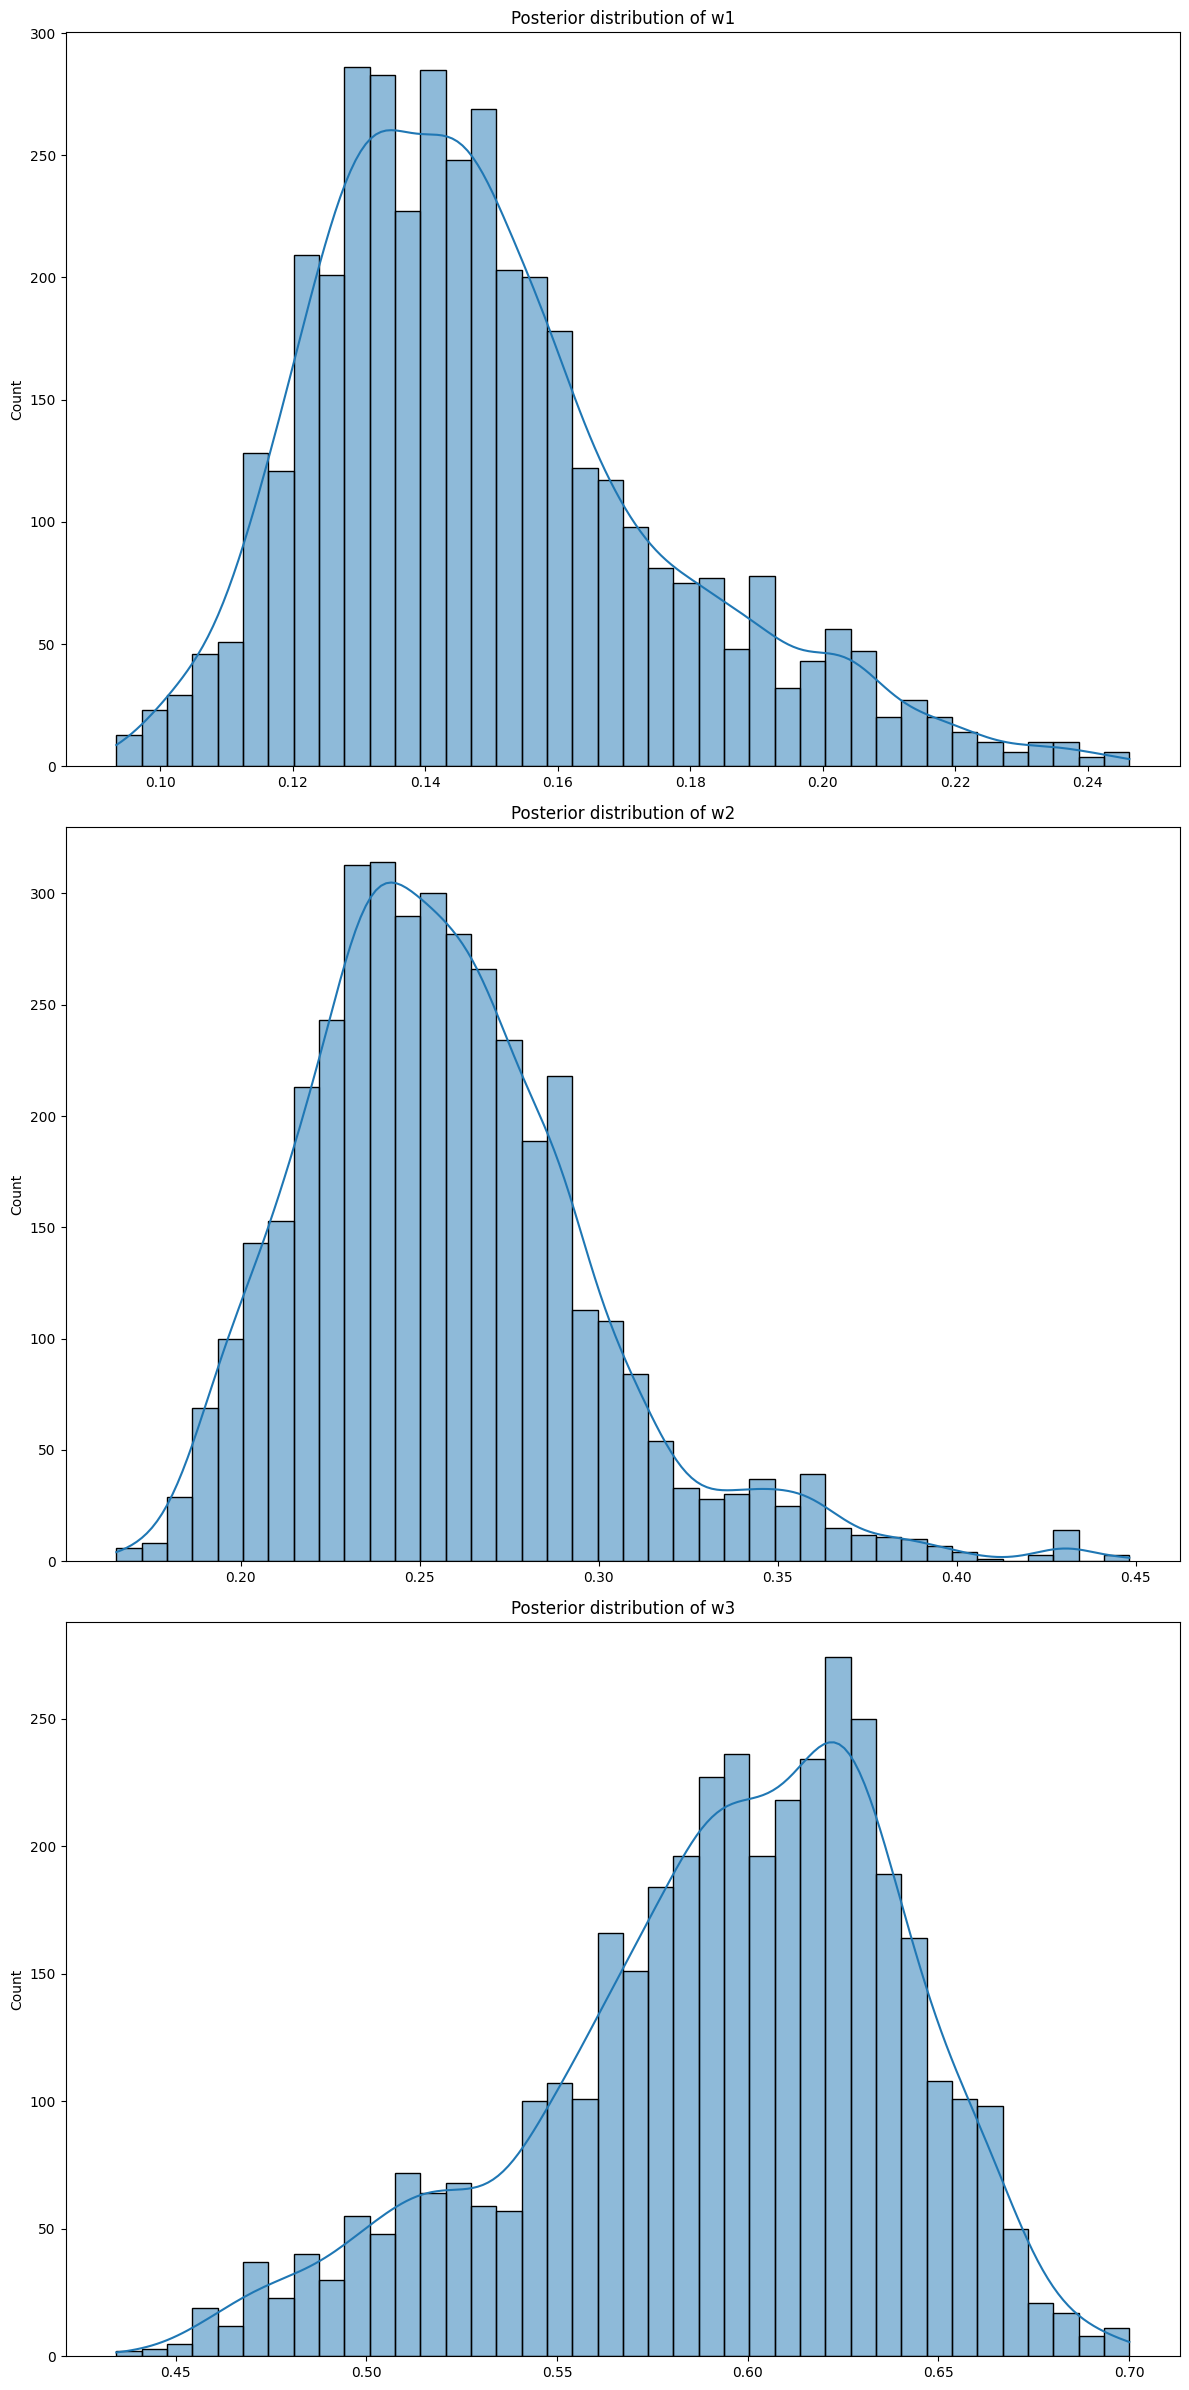

In [8]:
# Posterior distribution plots
fig, axs = plt.subplots(3, 1, figsize=(12, 24))

sns.histplot(w1_samples[burn_in:], kde=True, bins=40, ax=axs[0])
axs[0].set_title("Posterior distribution of w1")

sns.histplot(w2_samples[burn_in:], kde=True, bins=40, ax=axs[1])
axs[1].set_title("Posterior distribution of w2")

sns.histplot(w3_samples[burn_in:], kde=True, bins=40, ax=axs[2])
axs[2].set_title("Posterior distribution of w3")

plt.tight_layout()
plt.show()


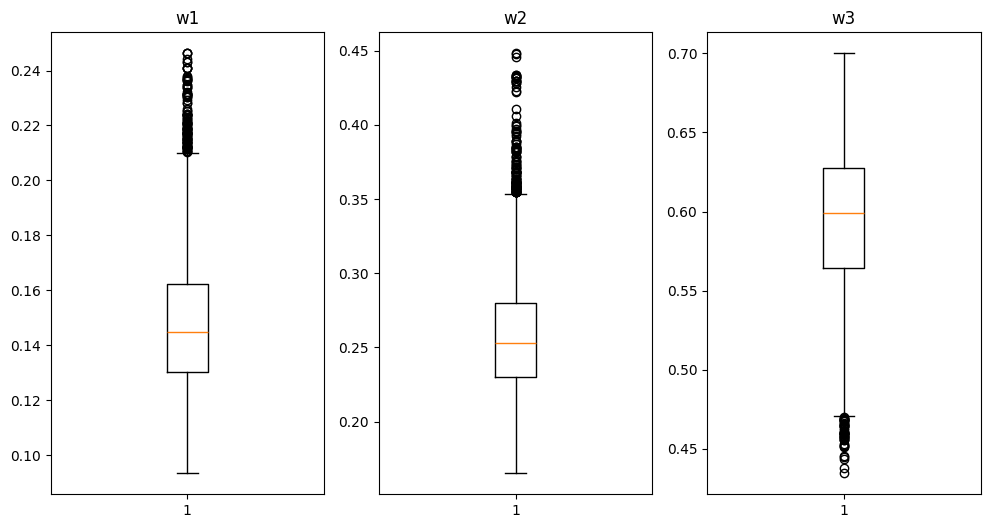

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1.boxplot(w1_samples[burn_in:])
ax1.set_title("w1")

ax2.boxplot(w2_samples[burn_in:])
ax2.set_title("w2")

ax3.boxplot(w3_samples[burn_in:])
ax3.set_title("w3")

plt.show()

In [10]:
'''
La fonction cycle permet de réaliser plusieurs itérations de l'algorithme de 
Metropolis-Hastings afin d'étudier ensuite des caractéristiques des distributions
'''

def cycle(nbre_cycles):
    liste_w1_empirical_expected = []
    liste_w2_empirical_expected = []
    liste_w3_empirical_expected = []
    for i in range(nbre_cycles):
        liste = metropolis_hastings(initial_omega, returns, iterations, std_prior, std_proposal)

        w1_samples = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
        w2_samples = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
        w3_samples = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]

        w1_expected = np.mean(w1_samples[burn_in:])
        w2_expected = np.mean(w2_samples[burn_in:])
        w3_expected = np.mean(w3_samples[burn_in:])
        
        liste_w1_empirical_expected.append(w1_expected)
        liste_w2_empirical_expected.append(w2_expected)
        liste_w3_empirical_expected.append(w3_expected)
        
    return [liste_w1_empirical_expected,liste_w2_empirical_expected,liste_w3_empirical_expected] 

In [11]:
#We initialize our parameters
initial_omega = [0.3,0.3,0.3]

returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 2000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

omega_réel = [0.1, 0.2, 0.7]

In [12]:
# We execute the Metropolis algorithm 100 times 
cycles = cycle(nbre_cycles = 10) #ça a pris 25 min pour 200 cycles et 6/7 min pour 50 cycles

In [13]:
# We compute the bias of our estimators to check the unbiasedness presented in the paper
def biais_estimateur(cycles):
    return statistics.mean(cycles[0]) - omega_réel[0], statistics.mean(cycles[1]) - omega_réel[1], statistics.mean(cycles[2]) - omega_réel[2]

biais_estimateur(cycles)

(-0.0038976517034903235, 0.06875625896297338, -0.05594926312387516)

We see that our estimators seem unbiased, as seen in the paper. 

In [14]:
# We compute the mean of our estimators 
def mean_estimateur(cycles):
    return statistics.mean(cycles[0]), statistics.mean(cycles[1]), statistics.mean(cycles[2])

mean_estimateur(cycles)

(0.09610234829650968, 0.2687562589629734, 0.6440507368761248)

The mean of the empirical expected value of our estimators are near the real values of the parameters. 

In [15]:
# We compute the Mean Square error of our estimator 
newcycles = [0, 0, 0]

# Soustraire la valeur réelle constante du paramère w1, w2 ou w3 à chaque élément de la liste
newcycles[0] = [(x - omega_réel[0])**2 for x in cycles[0]]
newcycles[1] = [(x - omega_réel[1])**2 for x in cycles[1]]
newcycles[2] = [(x - omega_réel[2])**2 for x in cycles[2]]

def mse_estimateur(omega_réel, cycles):
    return statistics.mean(newcycles[0]), statistics.mean(newcycles[1]), statistics.mean(newcycles[2])

mse_estimateur(omega_réel, cycles)

(0.00046721814182421056, 0.0061326494409941115, 0.005781679500867067)

We see that we have a small MSE. 

**The most important parameter is the variance of the estimators since our goal in this project is to check if the $\tilde{f}$ function allows to reduce the variance of the estimators while keeping the same expected value.**

In [16]:
# This is the most important parameter of our project : the variance of the estimators 
def variance_estimateur(cycles):
    return statistics.variance(cycles[0]), statistics.variance(cycles[1]), statistics.variance(cycles[2])

variance_estimateur(cycles)

(0.0005022516144694328, 0.0015613625493451735, 0.002945954951958274)

Our variance is in the order of 10^-4 which is quite a small variance. We will have to check if the second method reduces more the variance. 

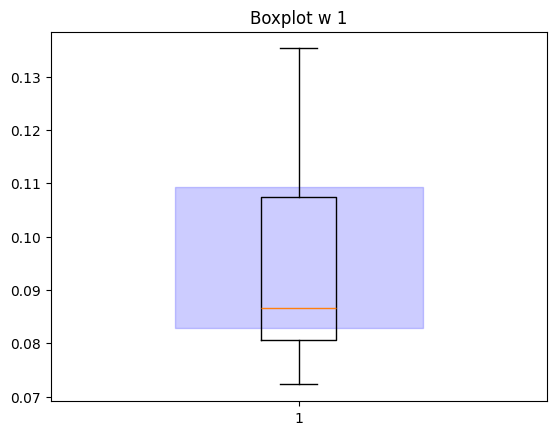

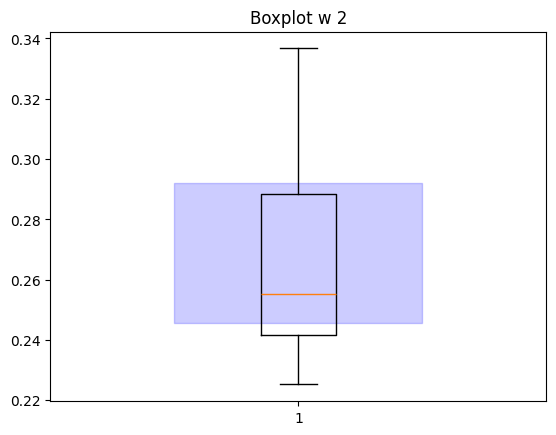

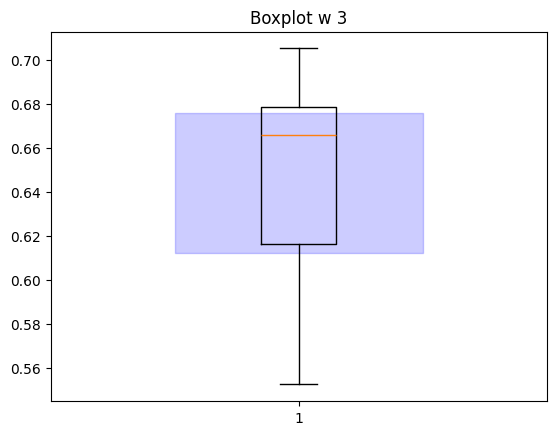

In [17]:
def boxplot(cycles):
    # Créer les boxplot afin de visualiser graphiquement la variance, la moyenne et les valeurs extrêmes
    for i in range(len(cycles)):
        fig, ax = plt.subplots()
        ax.boxplot(cycles[i])

        # Calculer les bornes de l'intervalle de confiance à 95%
        n = len(cycles[i])
        se = np.std(cycles[i]) / np.sqrt(n)
        m = np.mean(cycles[i])
        h = se * 1.96

        # Ajouter l'intervalle de confiance au graphique
        x = np.array([0.75, 1.25])
        y1 = m - h
        y2 = m + h
        ax.fill_between(x, y1, y2, color='blue', alpha=0.2)
        title = f'Boxplot w {i+1}'
        ax.set_title(title)
    # Afficher les graphiques
    plt.show()
    
boxplot(cycles)

**Example on real data** 

We now try on real data, so we extract datas to compute log-returns from exchange rates. 

"DEXUSEU" is the series codes or ticker of the time-series data that we retrieve from the FRED (Federal Reserve Economic Data) database. In this case, the series codes is for the daily exchange rate between the US dollar and the Euro.

In [18]:
start_date = "2021-01-01"
end_date = "2022-12-31"

df = pdr.get_data_fred(["DEXUSEU"], start_date, end_date)
df["returns"] = (df["DEXUSEU"] - df["DEXUSEU"].shift(1)) / df["DEXUSEU"].shift(1)
df["log_returns"] = np.log(df["returns"])
df = df.dropna()
returns_real = df["returns"].to_numpy()
returns_real_percentage = returns_real * 100

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


We fit a GARCH model with a function implemented on Python in order to then compare it with what we find with our Metropolis sampler. 

In [19]:
garch = arch.arch_model(returns_real, vol = 'GARCH', p=1, q=1)

res = garch.fit()

print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 999284337042.5713
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1140116310535748.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3399022695.140592
Iteration:      4,   Func. Count:     46,   Neg. LLF: -967.3132884490158
Optimization terminated successfully    (Exit mode 0)
            Current function value: -967.3132872476693
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                967.313
Distribution:                  Normal   AIC:                          -1926.63
Method:            Maximum Likelihood   BIC:                          -1913.02
                            

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.165e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
initial_omega = [0.3,0.3,0.3]

returns = returns_real_percentage

iterations = 5000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

/var/folders/dl/gt7zs7yx47xdn1_hyjv5m3tc0000gn/T/ipykernel_92435/205346029.py:14: RuntimeWarning: invalid value encountered in log
  loglikelihood = -0.5*T*np.log(2*np.pi) - 0.5*np.sum(np.log(var_h)) - 0.5*np.sum(returns**2/var_h)
/var/folders/dl/gt7zs7yx47xdn1_hyjv5m3tc0000gn/T/ipykernel_92435/205346029.py:46: RuntimeWarning: divide by zero encountered in log
  alpha = garch_loglikelihood(omega_star, returns) - garch_loglikelihood(omega, returns) + np.log(prior(omega_star,std_prior)) - np.log(prior(omega,std_prior))


Text(0, 0.5, 'omega')

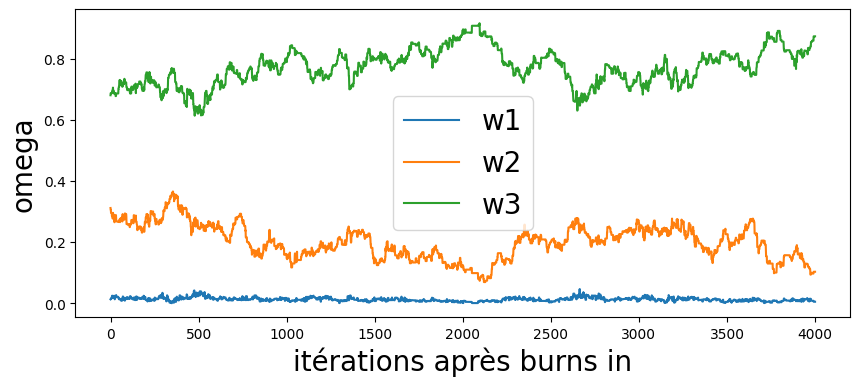

In [21]:
# Compute the expected values of w1, w2 and w3
liste = metropolis_hastings(initial_omega, returns, iterations, std_prior, std_proposal)

w1_samples = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
w2_samples = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
w3_samples = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]

plt.figure(figsize=(10,4))
plt.plot(w1_samples[burn_in:])
plt.plot(w2_samples[burn_in:])
plt.plot(w3_samples[burn_in:])
plt.legend(['w1','w2','w3'], fontsize=20)
plt.xlabel('itérations après burns in', fontsize=20)
plt.ylabel('omega', fontsize=20)
#plt.axvline(abscisse = 10, color='r', linestyle='--')

In [22]:
w1_expected = np.mean(w1_samples[burn_in:])
w2_expected = np.mean(w2_samples[burn_in:])
w3_expected = np.mean(w3_samples[burn_in:])

print("Expected values:")
print("w1 =", w1_expected)
print("w2 =", w2_expected)
print("w3 =", w3_expected)

Expected values:
w1 = 0.012797523846050011
w2 = 0.20139445288587265
w3 = 0.7714360162390421


We also have expected values near the real parameters found by the Python implemented Garch function, but the slightly difference could be explain by the fact that we have a very small $\omega_1$ which makes our empirical expected values not as close as the expected values as it could be. 

In [23]:
initial_omega = [0.3,0.3,0.3]

returns = returns_real_percentage

iterations = 2000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

In [24]:
# We execute the Metropolis algorithm 100 times 
cycles_real = cycle(nbre_cycles = 100) 

/var/folders/dl/gt7zs7yx47xdn1_hyjv5m3tc0000gn/T/ipykernel_92435/205346029.py:14: RuntimeWarning: invalid value encountered in log
  loglikelihood = -0.5*T*np.log(2*np.pi) - 0.5*np.sum(np.log(var_h)) - 0.5*np.sum(returns**2/var_h)
/var/folders/dl/gt7zs7yx47xdn1_hyjv5m3tc0000gn/T/ipykernel_92435/205346029.py:46: RuntimeWarning: divide by zero encountered in log
  alpha = garch_loglikelihood(omega_star, returns) - garch_loglikelihood(omega, returns) + np.log(prior(omega_star,std_prior)) - np.log(prior(omega,std_prior))


In [25]:
biais_estimateur(cycles_real)

(-0.08082005277002612, 0.027244344917744745, 0.028890937089533497)

In [26]:
mean_estimateur(cycles_real)

(0.019179947229973893, 0.22724434491774476, 0.7288909370895335)

In [27]:
variance_estimateur(cycles_real)

(0.0003258817640573182, 0.0064230439363100805, 0.013172450314476608)

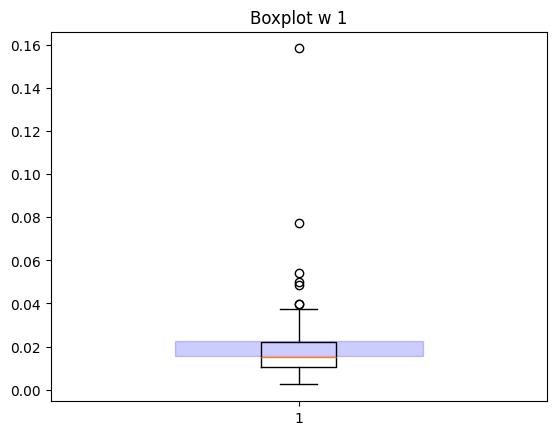

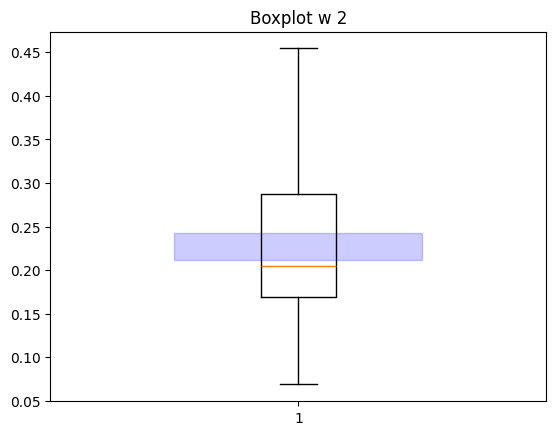

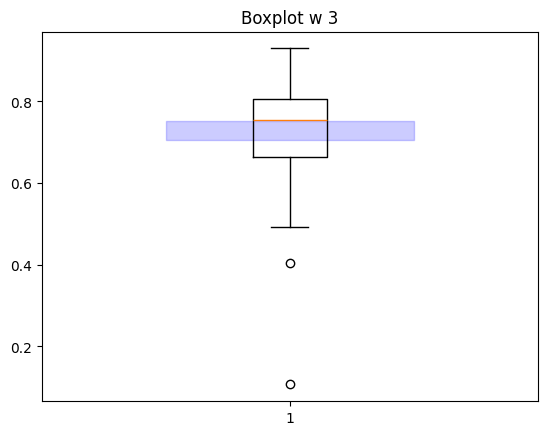

In [28]:
boxplot(cycles_real)

### **II)** Linear regression to compute the optimal coefficients of the control variates to reduce the variance of the first model in the 1st degree polynomial case *(Question 2)*

This second partof the article corresponds to the objective of the research paper which is to reduce the variance of the estimators of $\omega_1$, $\omega_2$ and $\omega_3$. Indeed, it uses the functions $H$ and $ψ$ in order to construct $$\frac{Hψ(x)}{\sqrt{\pi(x)}}$$ with the posterior distribution function $\pi$. 



Using the Schrödinger-type Hamiltonian H such that Hf is written:
\begin{equation}
    Hf = -2\sum_{i=1}^d\frac{\partial^2 f}{\partial x_i^2} + V(x)f
\end{equation}
and the trial function  $ψ(x) = P (x)*π(x)$ where $P$ is a polynomial, the the re-normalized function is:$\tilde{f}(x) = f(x) − \frac{1}{2}∆P(x) + ∇P(x) · z$ (Equation 8 of the article). where $z = −\frac{1}{2}∇lnπ(x)$ are the control variates, $∇$ denotes the gradient and $∆ = \sum_{i=1}^d\frac{\partial^2 }{\partial x_i^2}$. 

Therefore, in this 2nd question, as we use a first order polynomial case, we have $P(x) =  \sum_{i=1}^3a_i*x_i$, so $∆P(x) = 0$ and the formula of equation 8 becomes : $f(x) + a^T z$ where z is the vector of the 3 covariates. 

Our goal is now to find the vector of coefficients a which allows to reduce the variance. As asked in Question 2, we are going to explain how we use these control variates in this settings by doing a linear regression to find a. 

**Indeed, a can be computed by an OLS regression of $f(x)$ on $-z$.** 

**Indeed, when we do the regression of $f$ on $-z$, we empirically determine the value  
$\alpha = argmin_a\left(\sum_{i=1}^n (f(X_i) - (-z_i)^Ta)^2\right)$, which corresponds almost to the empirical expected value of $f(X)-a^T(-z) = f(X)+a^T(z) = \tilde{f}(x)$.**

**However, as we know that $Var(f(X)-a^T(-z)) = E((f(X)-a^T(-z))^2) - E(f(X)-a^T(-z))^2$ and that $E(f(X)-a^T(-z))^2 = E(\tilde{f}(x))^2 = E(f(x))^2$ in our case because we constructed it so that $\mu_f = \mu_{\tilde{f}}$. Therefore, finding the $a$ that minimizes the variance of $\tilde{f}$ only requires to find the $a$ that minimizes $E((f(X)-a^T(-z))^2)$ and so, in a linear regression, the only $a$ that minimizes the empirical expected value of $(f(X)-a^T(-z))^2$.**

**The optimal choice of a, that minimizes the variance of f(x), will therefore been given, as seen in Econometrics and in the paper, by the equation $a = E(zz^T)^{-1}E(zf)$.**

In order to do these regression, we therefore first had to compute the 3 control variates for the first order polynomial case: $\frac{\partial \ln \pi}{\partial \omega_i}$ *for* $i=1,2,3$. We computed the formula for the 3 values and we implemented them in the function *control_variate(omega, std, returns)*. 

In [29]:
# Defines the 3 controle variates with the formulas found for dln(pi)/dw_i
def control_variate(omega, std, returns):
    z = np.array([0.0, 0.0, 0.0])
    w1 = omega[0]
    w2 = omega[1]
    w3 = omega[2]
    n = len(list(returns)) # car jsp si returns est un array ou une liste pour l'instant 
    var_h = np.zeros(n)
    var_h[0] = np.var(returns)
    for i in range(1, n):
        var_h[i] = w1 + w2*returns[i-1]**2 + w3*var_h[i-1]
        
    # calcul de la dérivée de ln(posterior) par rapport à w1, i.e. la 1ère controle variate
    x1 = 0.0
    y1 = 0.0
    for i in range(0,n-1):
        x1 += (1.0/var_h[i+1]) * (1.0-np.exp((i)*np.log(w3)))/(1.0-w3)
        y1 += (returns[i+1]**2/var_h[i+1]**2) * ((1.0-np.exp((i)*np.log(w3)))/(1.0-w3))
    t1 = -w1/(std**2) - 0.5*x1 + 0.5*y1
    z[0] = -0.5*t1
    
    # calcul de la dérivée de ln(posterior) par rapport à w2 selon la formule trouvée
    x2 = 0.0
    y2 = 0.0
    h2 = returns[1]**2
    for i in range(1,n-2):
        x2 += (1.0/var_h[i+1]) * h2
        y2 += (returns[i+1]**2)/(var_h[i+1]**2) * h2 
        h2 += returns[i+1]**2 + w3*h2
    t2 = -w2/(std**2) - 0.5*x2 + 0.5*y2
    z[1] = -0.5*t2
    
    # calcul de la dérivée de ln(posterior) par rapport à w3
    x3 = 0.0
    y3 = 0.0
    h3 = var_h[1]
    for i in range(1,n-2):
        x3 += (1.0/var_h[i+1]) * h3
        y3 += (returns[i+1]**2/var_h[i+1]**2) * h3
        h3 += var_h[i+1]**2 + w3*h3
    t3 = -w3/(std**2) - 0.5*x3 + 0.5*y3
    z[2] = - 0.5 * t3
    return(z.tolist())

The Metropolis algorithm in function *metropolis_hastings_Q2* is exactly the same as in I°, except for the fact that we now not only construct the chain for $\omega_i$ which corresponds to the $f(x)$ but also the chain for the $z_i$ thanks to the function *control_variate(omega, std, returns)*. This function now returns the acceptance rate and the 2 chains. 

In [30]:
# Define the Metropolis-Hastings sampler by taking into account the control variates 
def metropolis_hastings_Q2(initial_omega, returns, iterations,std_prior, std_proposal):
    omega = initial_omega
    #Initialization of Z_i
    initial_z = control_variate(omega, std_prior, returns)
    omega_samplers = [initial_omega]
    accepted = np.zeros(iterations)
    #Initialization of the Z_i chain 
    z_samplers = [initial_z]
    for i in range(iterations):
        omega_star = proposal(omega, std_proposal)
        alpha = garch_loglikelihood(omega_star, returns) - garch_loglikelihood(omega, returns) + np.log(prior(omega_star,std_prior)) - np.log(prior(omega,std_prior))
        if 0 < alpha:
            omega = omega_star
            accepted[i] = 1
        else:
            u = np.random.uniform()
            if np.log(u) < alpha: 
                omega = omega_star
                accepted[i] = 0
        omega_samplers.append(omega)
        # We complete our chain 
        z_samplers.append(control_variate(omega, std_prior, returns))
    acceptance_rate = np.sum(accepted)/len(accepted)*100
    return omega_samplers, acceptance_rate, z_samplers

   When we did all the computation, we realised that it was easier to compute the *posterior density* function as well as the *post* and *gradient* functon in order to do the computation of $\frac{\partial \ln \pi}{\partial \omega_i}$ *for* $i=1,2,3$, so we created these functions and we applied them to our *metropolis hastings* function of Q1 instead of the 2 cells above. 

In [31]:
# Posterior desity function of the GARCH(1,1) model
def posterior_density(returns, omega, std_prior):
    n = len(returns)
    variances = np.zeros(n)
    variances[0] = np.var(returns)
    for i in range(1, n):
        variances[i] = omega[0] + omega[1] * returns[i-1]**2 + omega[2] * variances[i-1]
    ecart_type = np.sqrt(variances)
    log_likelihood = np.sum(norm.logpdf(returns, 0, ecart_type))
    log_prior = np.log(prior(omega, std_prior)) 
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [32]:
# Function that returns the previous one, it will be used for the gradient later
def _post(omega):
    return posterior_density(returns, omega, std_prior)

In [33]:
def gradient(f, x):
    
    """
    It computes the gradient of function f at a point x.
    f is a function with many variables.
    x is the vector that that represents the point where the gradient is computed. 
    """
    h = 1e-6
    gradient = np.zeros_like(x)
    for i in range(x.size):
        x_plus_h = x.copy()
        x_plus_h[i] += h
        gradient[i] = (f(x_plus_h) - f(x)) / h
    return gradient

**Example on simulated data**

In [34]:
def simulate_garch(omega, T):
    h0 = omega[0]/(1 - omega[1] - omega[2])
    std_h = [np.sqrt(h0)]
    returns = [norm.rvs(loc = 0, scale = np.sqrt(h0))]
    for i in range(1,T):
        #formula of h_i defined in the GARCH(1,1)
        h_i = omega[0] + omega[1]* returns[i-1]**2 + omega[2]* std_h[i-1]**2
        std_h.append(np.sqrt(h_i))
        #the returns are normally distributed with a lmean of 0 and a variance of h_i
        returns.append(norm.rvs(loc = 0, scale = np.sqrt(h_i)))
    return np.asarray(returns), std_h 

In [35]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 5000
burn_in = 1000

std_prior = 10
std_proposal = 0.01

**This next function *w_tilde* creates a chain of *w_i* thanks to Question 1, then it computes the *z_i* and stocks them in arrays. Then, we do the regression of Y, which corresponds to the w_i, on Z, which corresponds to the z_i, in order to find the optimal coefficients for the control variates z_i. Finally, this function computes the $a^T(-z))$. It returns the $w_i$ like in Question 1 as well as the $a^T(z_i))$.**

In [55]:
def w_tilde():

    # We run the basic Metropolis Sampler
    liste = metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)
    
    # Chain of w_i
    # We store the values of w1, w2 and w3 
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]
    # We create a vector omega 
    w = np.column_stack((w1, w2, w3))

    # Computation of the z_i
    # We compute the gradient for each w = [w1,w2,w3] generated in the Chain thanks to our gradient function
    x = [gradient(_post, np.asarray(omega)) for omega in w]
    # We store the gradients and we multiply by 0.5 since the control variates are
    x1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in x]
    x1 = [0.5*x for x in x1]
    x2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in x]
    x2 = [0.5*x for x in x2]
    x3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in x]
    x3 = [0.5*x for x in x3]
    # We store these 3 control variates in an array 
    z = np.column_stack((x1, x2, x3))

    # We store our data in arrays afetr burn in 
    Y = np.array(w[burn_in:])
    Z = np.array(z[burn_in:])

    # We create a linear regression object 
    regression = LinearRegression()

    # We train the model 
    regression.fit(Z, Y)

    # We store the optimal coefficients of the 3 regression 
    a = regression.coef_

    # Imprimer les coefficients de régression
    print("Coefficients de a de la régression de w sur les control variates: ", a)

    # We store the optimal coefficients as lists
    coeffs_w1 = a.tolist()

    # We compute a transposed times Z and we add a -1 since we do in fact the regression of W on -Z. 
    aTz = np.dot(a,(-Z).T)

    trans = aTz.T

    trans_w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in trans]
    trans_w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in trans]
    trans_w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in trans]

    return w1[burn_in:], trans_w1, w2[burn_in:], trans_w2, w3[burn_in:], trans_w3

In [56]:
w_tilde = w_tilde()

Coefficients de a de la régression de w sur les control variates:  [[-0.00337459 -0.00130668  0.00507161]
 [-0.00141838 -0.0024159   0.00346964]
 [ 0.00516077  0.00336728 -0.00906718]]


In [38]:
# Computes the sum of 2 lists
def sum_list(liste1, liste2):
    result = []
    for i in range(len(liste1)):
        somme = liste1[i] + liste2[i]
        result.append(somme)
    return result
    

**At the end, instead of computing the mean (empirical expected value) of $f(x)$, we compute the mean of $\tilde{f}(x)$ by adding to the mean of $f$ the mean of $a^Tz$. We are supposed to have approximatively the same expected value, but a lower variance.**

The 3 following functions return the results to compare the expected values of $w1$ (Q1) and $w_1 tilde$ (Q2) as well as their variance to see that the ZV MCMC estimator of Q2 has the same expected value as in Q1 but with a lower variance. 

In [39]:
# Results for 
def w1_results(w):
    w1 = w_tilde[0]
    transw1 = w_tilde[1]
    w1_tilde = sum_list(w1, transw1)
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

Expected value of w1 = 0.07289811376817025
Expected value of w1_tilde = 0.0716935754659317
Variance of w1 = 0.0003790593066657852
Variance of w1_tilde = 7.385914209094788e-05


In [40]:
# Results for 
def w2_results(w):
    w2 = w_tilde[2]
    transw2 = w_tilde[3]
    w2_tilde = sum_list(w2, transw2)
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

print("Expected value of w2 =", w2_results(w_tilde)[0])
print("Expected value of w2_tilde =", w2_results(w_tilde)[1])
print("Variance of w2 =", w2_results(w_tilde)[2])
print("Variance of w2_tilde =", w2_results(w_tilde)[3]) 

Expected value of w2 = 0.16754375702720495
Expected value of w2_tilde = 0.1611088029118249
Variance of w2 = 0.0008300617069195406
Variance of w2_tilde = 0.00010865041522434041


In [41]:
# Results for 
def w3_results(w):
    w3 = w_tilde[4]
    transw3 = w_tilde[5]
    w3_tilde = sum_list(w3, transw3)
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

print("Expected value of w3 =", w3_results(w_tilde)[0])
print("Expected value of w3_tilde =", w3_results(w_tilde)[1])
print("Variance of w1 =", w3_results(w_tilde)[2])
print("Variance of w1_tilde =", w3_results(w_tilde)[3]) 

Expected value of w3 = 0.7608091071588651
Expected value of w3_tilde = 0.7675338645852686
Variance of w1 = 0.0012473153633018419
Variance of w1_tilde = 0.00022827060929825436


**As the the 3 cells above show, we have, thanks to the 2nd method, the same expected value for the $w_i$ but we succeeded in reducing the variance by a factor of 10 approximatively. Therefore, the ZV MCMC works well with control variates.**

**Markov Chain Metropolis sampler plots**

This next function allow to plot the trajectories of w_i and w_i tilde. 

In [42]:
def plot_comparision(w,w_tilde, name): 
    # We plot the different trajectories 
    plt.figure(figsize=(10,4))
    plt.plot(w)
    plt.plot(w_tilde)
    plt.legend(['MCMC','ZV MCMC'], fontsize=20)
    plt.xlabel('Itérations après burns in', fontsize=20)
    plt.title('Comparision of the Markov Chain generated for ' + name + ' between MCMC and ZV MCMC', fontsize=20)
    plt.ylabel('omega', fontsize=20)

In [53]:
w1_results(w_tilde)[4]

[0.07062390383448269,
 0.06648064029419623,
 0.06648064029419623,
 0.06648064029419623,
 0.06913452320439281,
 0.07656908312201305,
 0.07882337577281821,
 0.07882337577281821,
 0.07986787800714264,
 0.07986787800714264,
 0.08250156829677334,
 0.08250156829677334,
 0.08250156829677334,
 0.07877634856965487,
 0.07877634856965487,
 0.07877634856965487,
 0.08424094471266952,
 0.07486972587133511,
 0.07486972587133511,
 0.07486972587133511,
 0.07546933718710076,
 0.07595162839207519,
 0.06945349239600615,
 0.06945349239600615,
 0.06945349239600615,
 0.06945349239600615,
 0.07494961139834004,
 0.07494961139834004,
 0.07375025573745214,
 0.07375025573745214,
 0.07375025573745214,
 0.07375025573745214,
 0.07407789136666082,
 0.07102803616222764,
 0.07208667117941218,
 0.07208667117941218,
 0.07208667117941218,
 0.07208667117941218,
 0.06715590469692864,
 0.06715590469692864,
 0.06715590469692864,
 0.06715590469692864,
 0.06708669129515903,
 0.08100602481766529,
 0.06763148595269972,
 0.0698344

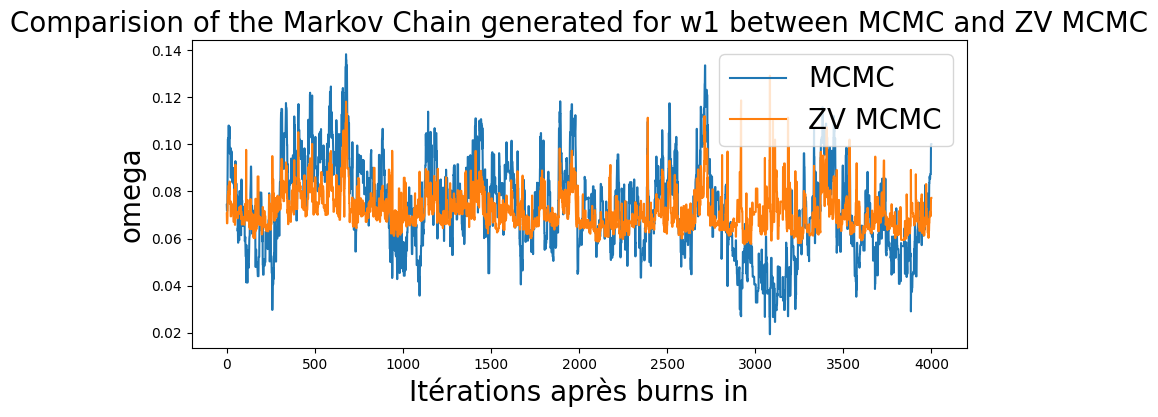

In [43]:
#w_tilde[0] correspond en réalité à w1 de la Q1
plot_comparision(w_tilde[0], w1_results(w_tilde)[4],'w1')

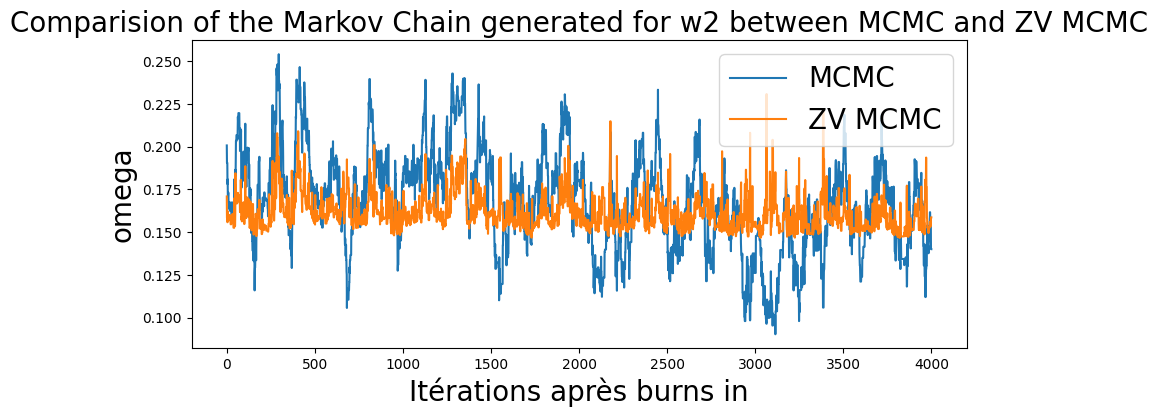

In [44]:
plot_comparision(w_tilde[2],w2_results(w_tilde)[4],'w2')

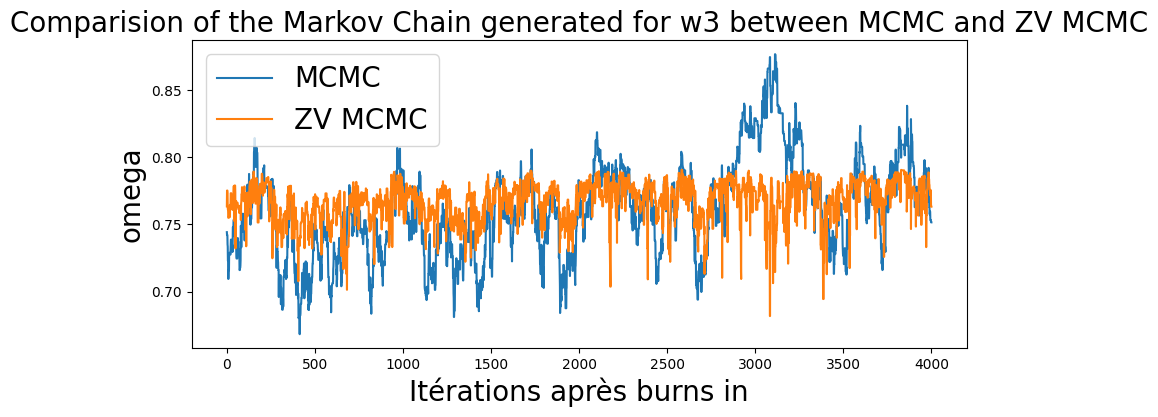

In [45]:
plot_comparision(w_tilde[4],w3_results(w_tilde)[4],'w3')

**Graphically, we can see that the variance of the $w_i$ tilde is reduced for all $i$ in 1, 2, 3.**

**Boxplots**

In [46]:
def boxplot_comparision(w, w_tilde, name):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots()
    ax.boxplot([w, w_tilde])
    ax.set_xticklabels(['MCMC', 'ZC-MCMC'])
    ax.set_title('Comparision of the boxplot of the Markov Chain generated for ' + name + ' between MCMC and ZV MCMC')
    plt.show()

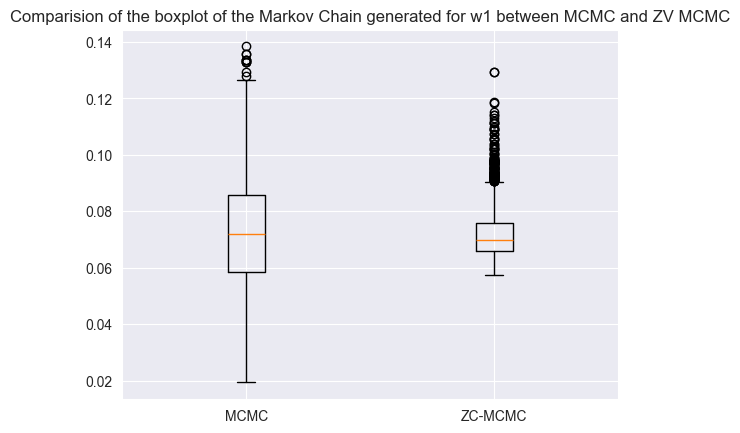

In [47]:
boxplot_comparision(w_tilde[0], w1_results(w_tilde)[4], 'w1')

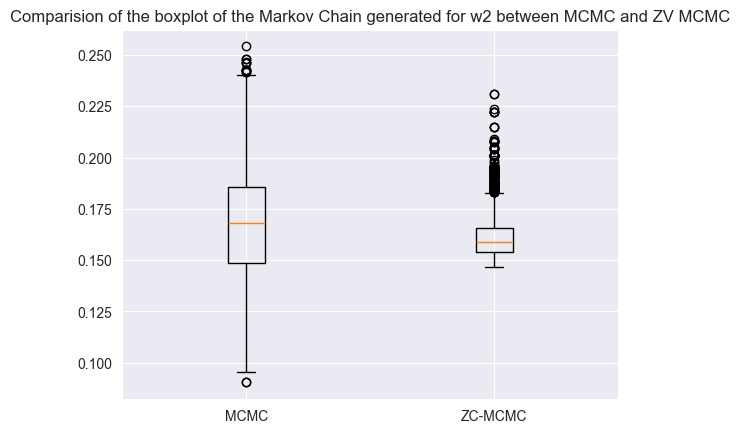

In [48]:
boxplot_comparision(w_tilde[2], w2_results(w_tilde)[4], 'w2')

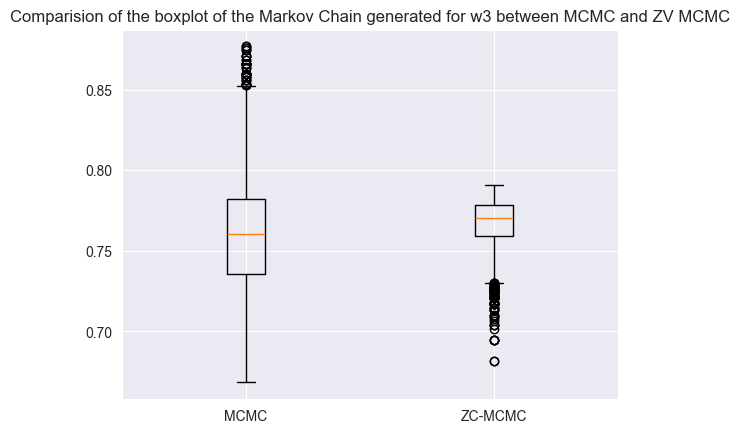

In [49]:
boxplot_comparision(w_tilde[4], w3_results(w_tilde)[4], 'w3')

It shows the distribution of our $\tilde{f}(w_i)$ and especially the reduction of the variacne by a factor 10. 

**Performing and storing multiple iterations of the Metropolis Hasting algorithm defined in Q2 and the resulting list of estimators**

In [50]:
'''
The cycle function allows several iterations of the 
Metropolis-Hastings algorithm in order to study the characteristics of the distributions
and to obtain for the 3 f(w_i) a list of estimators of w_i.
'''

def cycle_Q2(nbre_cycles):
    liste_w1_CV = []
    liste_w2_CV = []
    liste_w3_CV = []
    
    liste_w1_noCV = []
    liste_w2_noCV = []
    liste_w3_noCV = []
    for i in range(nbre_cycles):
        # We run the basic Metropolis Sampler
        liste = metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)

        # Chain of w_i
        # We store the values of w1, w2 and w3 
        w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
        w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
        w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]
        # We create a vector omega 
        w = np.column_stack((w1, w2, w3))

        # Computation of the z_i
        # We compute the gradient for each w = [w1,w2,w3] generated in the Chain thanks to our gradient function
        x = [gradient(_post, np.asarray(omega)) for omega in w]
        # We store the gradients and we multiply by 0.5 since the control variates are
        x1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in x]
        x1 = [0.5*x for x in x1]
        x2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in x]
        x2 = [0.5*x for x in x2]
        x3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in x]
        x3 = [0.5*x for x in x3]
        # We store these 3 control variates in an array 
        z = np.column_stack((x1, x2, x3))

        # We store our data in arrays afetr burn in 
        Y = np.array(w[burn_in:])
        Z = np.array(z[burn_in:])

        # We create a linear regression object 
        regression = LinearRegression()

        # We train the model 
        regression.fit(Z, Y)

        # We store the optimal coefficients of the 3 regression 
        a = regression.coef_

        # We store the optimal coefficients as lists
        coeffs_w1 = a.tolist()

        # We compute a transposed times Z and we add a -1 since we do in fact the regression of W on -Z. 
        aTz = np.dot(a,(-Z).T)

        trans = aTz.T

        trans_w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in trans]
        trans_w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in trans]
        trans_w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in trans]
        
        w1_tilde = sum_list(w1[burn_in:], trans_w1)
        w2_tilde = sum_list(w2[burn_in:], trans_w2)
        w3_tilde = sum_list(w3[burn_in:], trans_w3)

        liste_w1_noCV.append(np.mean(w1[burn_in:]))
        liste_w2_noCV.append(np.mean(w2[burn_in:]))
        liste_w3_noCV.append(np.mean(w3[burn_in:]))

        liste_w1_CV.append(np.mean(w1_tilde))
        liste_w2_CV.append(np.mean(w2_tilde))
        liste_w3_CV.append(np.mean(w3_tilde))
        
    return [liste_w1_CV,liste_w2_CV,liste_w3_CV], [liste_w1_noCV, liste_w2_noCV, liste_w3_noCV]

**Example on simulated data**

In [51]:
# Initialisation of the parameters and creation of the list of returns 
initial_omega = [0.3,0.3,0.3]

returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]
#returns = returns_real_percentage

iterations = 2000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

omega_réel = [0.1, 0.2, 0.7]

In [52]:
# We apply number of cycle times the metropolis algorithm defined in Q2
cycles_Q2 = cycle_Q2(nbre_cycles = 20) #it took more 30 min for 50 cycles

KeyboardInterrupt: 

In [ ]:
biais_estimateur(cycles_Q2[0]), biais_estimateur(cycles_Q2[1])

((0.0004716680236732801, 0.00247844490710894, -0.0009039596509726744),
 (0.0025184824788179877, 0.0023900925678660145, -0.0025509120814032338))

**We see that our estimator is still unbiased since they have approximatively the same empirical (and real) expected value as earlier.**

In [ ]:
mean_estimateur(cycles_Q2[0]), mean_estimateur(cycles_Q2[1])

((0.10047166802367329, 0.20247844490710895, 0.6990960403490273),
 (0.102518482478818, 0.20239009256786603, 0.6974490879185967))

**Our estimators have the same expected value, as expected based on the paper.**

In [ ]:
# Variance pour l'estimateur ZV MCMC 
variance_estimateur(cycles_Q2[0])

(3.955926159801435e-05, 5.189880508266066e-05, 0.00013924067715277924)

In [ ]:
# Variance pour l'estimateur MCMC 
variance_estimateur(cycles_Q2[1])

(0.00033936588375850285, 0.0005369286322137552, 0.0015261784714813464)

**As expected, we can see that adding the control variates allowed to reduce the variance of the estimators.**

We resume these information graphically in the boxplots below, where we can especialy see that the expected value is the same but the variance is smaller for Q2 when we added the control variates to create $\tilde{f}$. 

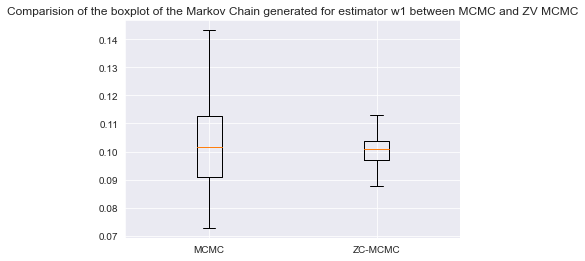

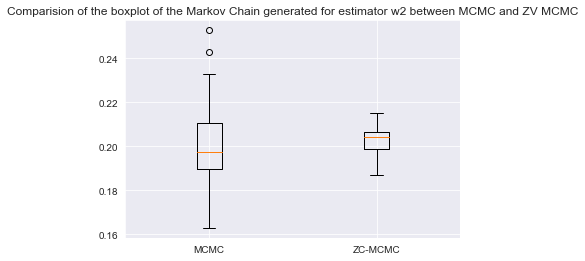

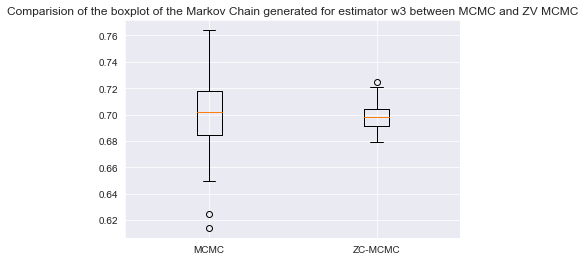

In [ ]:
boxplot_comparision(cycles_Q2[1][0], cycles_Q2[0][0], 'estimator w1')
boxplot_comparision(cycles_Q2[1][1], cycles_Q2[0][1], 'estimator w2')
boxplot_comparision(cycles_Q2[1][2], cycles_Q2[0][2], 'estimator w3')

### **III)** Implementation of a method based on Lasso regression in the case of a high degree polynomial (large set if control variates) and comparison with the naive approach *(Question 3)*

**Issues with a large number of control variates**

**When the number of control variates become too large, the linear regression approach of Step 2 may become too expensive. Let's explain why.**

First of all, when we consider <polynomials, increasing by 1 the degree of the polynomial function increases a lot the number of control variates since, in a $d$-dimensionnal space, a polynomial of order $p$ provides $\binom{d+p}{d}-1$ control variates according to the first paper. Therefore, for instance in our example where we are in a 3-dimensional space, we effectively have $\binom{1+3}{1}-1 = \binom{4}{1}-1 = 3$ control variates $z_1, z_2$ and $z_3$ for the first order polynomial case. For the 2 order polynomial case, we would have $z_1, z_2, z_3, z_1*z_2, z_3*z_3, z_1*z_3, z_1^2, z_2^2$ and $z_3^2$ which effectively corresponds to  $\binom{2+3}{2}-1 = \binom{5}{2}-1 = 9$ control variates. In the same way, we would have $\binom{3+3}{3}-1 = \binom{6}{3}-1 = 19$ for the 3rd order polynomial case. 

On the other side, the second paper states that the computation time of the OLS method is of the order $nm^2 + m^3 + nt$, where $n$ is the number of samples and $m$ the number of control variates. Indeed, when doing OLS, we need to compute $(𝑋′𝑋)^{−1}𝑋′𝑌$. In general, the complexity of the matrix product $AB$ of two matrices $A$ and $B$ with dimensions $a \times b$ and $b \times c$, respectively, can be expressed as $O(abc)$. Therefore, 

a) The matrix product $X'X$ has a complexity of $O(p^2n)$.

b) The matrix-vector product $X'Y$ has a complexity of $O(pn)$.

c) The inverse $(X'X)^{-1}$ has a complexity of $O(p^3)$.

Thus, the overall complexity of these operations is $O(np^2 + p^3)$.

As we saw that the number of controle variates increases rapidly when we increase the degree of the polynomial, this can therefore lead to a significant increase in the complexity of the computation when searching for the optimal coefficients by doing an OLS regression.
That is why the second paper puts forward a solution to this problem which consists of using a Lasso regression to reduce the number of control variates used. 

**Method with Lasso regression**

Indeed, in statistics and machine learning, LASSO (least absolute shrinkage and selection operator) is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the resulting statistical model.

It is similar to the OLS but with an additional term which corresponds to lambda, an hyperparameter to find, times the norm 1 of the vector of coefficients. Therefore, in a LASSO regression, we search the parameters that satisfies this : $$\displaystyle \min_{\beta \in \mathbb{R}^p} {\frac{1}{N}} |y - X\beta|_2^2 + \lambda |\beta|_1.$$

**Therefore, we can adapt the method described in the second paper as the LSLasso method in order to deal with the issue of a large set of control variates. We are going to do the second order polynomial case here.**

Indeed, the method that we are going to apply is:

**1)** We are first going to compute the 9 control variates based on the derivative of ln(posterior) based on these control variates as we did with the 3 control variates in II° with the second order polynomial case. We use the gradient function as in question 2 in order to compute $z_1$, $z_2$ and $z_3$, and then, the next 6 control variates that we are going to use are $z_1\times z_2$, $z_1\times z_3$, $z_2\times z_3$, $z_1^2$, $z_2^2$ and $z_3^2$. 

**2)** Then, we are going to do a LASSO Cross Validation (LassoCV) to regress the $f(w_i)$ on the vector of control variates $[z_i]$ as in Question 2 (but we have 9 control variates instead of 3 so 9 parameters to estimate for each $w_i$) in order to find the optimal hyperparameter $\lambda$.

**3)** Then, with this optimal hyperparameter $\lambda$, we are going to do a LASSO Regression of $f(w_i) = w_i$ on $[z_i]$, using subsampling to decrease the computation time, in order to put some of the coefficients to 0 and therefore to know which control variates we are going to keep for the last OLS regression. 

**4)** With the control variates kept (after LASSO), we are going to sdo our OLS regression to find the optimal parameters of the control variates.

**5)** Finally, we can compute for instance the empirical expected value (mean) of each $\tilde{f}(w_i)$ in order to see if we have the same expected value as with only $f(w_i)$ but with a lower variance, which is the purpose of the control variates.

In this question, we are focusing on 2nd order polynomials. As we know that, for quadratic polynomials $P(x) = a^T\times x + \frac{1}{2}\times x^TBx$ (formula of the paper), the re-normalized $\tilde{f}$ is now:$\tilde{f}(x) = f(x) - \frac{1}{2}\operatorname{tr}(B) + (a + Bx)^Tz$. Here, if we note $\alpha_1$, $\alpha_2$, $\alpha_3$, $\alpha_{12}$, $\alpha_{13}$, $\alpha_{23}$, $\alpha_{11}$, $\alpha_{22}$ and $\alpha_{33}$ the coefficients of $z_1$, $z_2$, $z_3$,$z_1\times z_2$, $z_1\times z_3$, $z_2\times z_3$, $z_1^2$, $z_2^2$ and $z_3^2$, then we have : $a = [\alpha_1, \alpha_2, \alpha_3]$ and 
$ B = \begin{pmatrix}
\alpha_{11} & \alpha_{12} & \alpha_{13} \\
\alpha_{21} & \alpha_{22} & \alpha_{23} \\
\alpha_{31} & \alpha_{32} & \alpha_{33} \\
\end{pmatrix}$ but with B symmetric so we only have 6 distinct coefficients in this matrix. 

**Coding the methodology**

**Example on simulated data**

As usual, we generate our data following a Garch Bayesian Model. 

In [ ]:
def simulate_garch(omega, T):
    h0 = omega[0]/(1 - omega[1] - omega[2])
    std_h = [np.sqrt(h0)]
    returns = [norm.rvs(loc = 0, scale = np.sqrt(h0))]
    for i in range(1,T):
        #formula of h_i defined in the GARCH(1,1)
        h_i = omega[0] + omega[1]* returns[i-1]**2 + omega[2]* std_h[i-1]**2
        std_h.append(np.sqrt(h_i))
        #the returns are normally distributed with a lmean of 0 and a variance of h_i
        returns.append(norm.rvs(loc = 0, scale = np.sqrt(h_i)))
    return np.asarray(returns), std_h 

In [ ]:
initial_omega = [0.3,0.3,0.3]

returns = simulate_garch(omega = [0.1,0.2,0.7], T = 1000)[0]

iterations = 2000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

These functions were already defined in the previous question. 

In [ ]:
# Posterior desity function of the GARCH(1,1) model
def posterior_density(returns, omega, std_prior):
    n = len(returns)
    variances = np.zeros(n)
    variances[0] = np.var(returns)
    for i in range(1, n):
        variances[i] = omega[0] + omega[1] * returns[i-1]**2 + omega[2] * variances[i-1]
    std = np.sqrt(variances)
    log_likelihood = np.sum(norm.logpdf(returns, 0, std))
    log_prior = np.log(prior(omega, std_prior)) 
    log_posterior = log_likelihood + log_prior
    return log_posterior

# Function that returns the previous one, it will be used for the gradient later
def _post(omega):
    return posterior_density(returns, omega, std_prior)

def gradient(f, x):
    
    """
    It computes the gradient of function f at a point x.
    f is a function with many variables.
    x is the vector that that represents the point where the gradient is computed. 
    """
    h = 1e-6
    gradient = np.zeros_like(x)
    for i in range(x.size):
        x_plus_h = x.copy()
        x_plus_h[i] += h
        gradient[i] = (f(x_plus_h) - f(x)) / h
    return gradient

In [ ]:
# This function will be useful for the following of our code
# It allows to create a list of the products element from list1 by element of list2
# It is used to compute the next 6 control variates based on z_1, z_2 and z_3
def list_product(x,y):
    result = []
    # The 2 lists must be of same length
    for i in range(len(x)):
        product = x[i] * y[i]
        result.append(product)
    return result

In [ ]:
# We run the basic Metropolis Sampler
liste = metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)

# We store the values of w1, w2 and w3 
w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]

# We create a vector omega 
w = np.column_stack((w1, w2, w3))

# We compute the gradient for each w = [w1,w2,w3] generated in the Chain thanks to our gradient function
x = [gradient(_post, np.asarray(omega)) for omega in w]

# We store the gradients and we multiply by 0.5 like in the formula of the article
x1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in x]
x1 = [0.5*x for x in x1]

x2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in x]
x2 = [0.5*x for x in x2]

x3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in x]
x3 = [0.5*x for x in x3]

# We construct the 6 other control variates thanks to the function list_product
x1x2 = list_product(x1,x2)
x1x3 = list_product(x1,x3)
x2x3 = list_product(x2,x3)
x1_square = list_product(x1,x1)
x2_square = list_product(x2,x2)
x3_square = list_product(x3,x3)

# We store these 9 control variates in an array 
z = np.column_stack((x1, x2, x3, x1x2, x2x3, x1x3, x1_square, x2_square, x3_square))

# We store our data in arrays after burn in 
Y = np.array(w[burn_in:])
Z = np.array(z[burn_in:])

In [ ]:
# We also store 
Y1 = np.array(w1[burn_in:])
Y2 = np.array(w2[burn_in:])
Y3 = np.array(w3[burn_in:])

In [ ]:
# We standardize or not our control variates, as it is usually done in a Lasso Regression. 

#scaler = StandardScaler()
#Z = scaler.fit_transform(Z)

In [ ]:
alphas = [0.0001, 0.0001, 0.001, 0.1, 1,1.5]

# We do a Lasso Cross Validation in order to find the optimal parameter lambda : step 2 of the method
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(Z,Y1)

print("Optimal lambda:", lasso_cv.alpha_)

Optimal lambda: 0.17221281754008638


/Users/sachaapelbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038409982551718125, tolerance: 4.351547357909134e-05
  model = cd_fast.enet_coordinate_descent_gram(
/Users/sachaapelbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000543095304140484, tolerance: 4.351547357909134e-05
  model = cd_fast.enet_coordinate_descent_gram(
/Users/sachaapelbaum/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014321881297152395, tolerance: 4.351547357909134e-05
  model = cd_fast.enet_coordinate_descent_gram(
/Users/sa

In [ ]:
# With the optimal lambda, we do a Lasso regression to select the variables : Step 3 of the method
lasso_bestmodel = Lasso(alpha=lasso_cv.alpha_)
lasso_bestmodel.fit(Y,Z)

array([[  -553.41125474,     -0.        ,   -233.12317215],
       [    -0.        ,   -306.53380556,    -89.25326559],
       [    -0.        ,     -0.        ,   -120.57534663],
       [ -3648.13074495,  -3280.17412212,   4345.12436071],
       [ -3805.19315215,  -4940.08615264,   4384.36840516],
       [  1420.61961738,    734.73709035,  12263.66920225],
       [  2937.15751271,    315.9978156 ,  12577.81507715],
       [ -8021.32524001, -11580.07166716,  -2421.19515867],
       [   418.45499771,    811.42839808,  11637.22485307]])

In [ ]:
coeff_lasso = lasso_bestmodel.coef_

array([[  -553.41125474,     -0.        ,   -233.12317215],
       [    -0.        ,   -306.53380556,    -89.25326559],
       [    -0.        ,     -0.        ,   -120.57534663],
       [ -3648.13074495,  -3280.17412212,   4345.12436071],
       [ -3805.19315215,  -4940.08615264,   4384.36840516],
       [  1420.61961738,    734.73709035,  12263.66920225],
       [  2937.15751271,    315.9978156 ,  12577.81507715],
       [ -8021.32524001, -11580.07166716,  -2421.19515867],
       [   418.45499771,    811.42839808,  11637.22485307]])

In [ ]:
# This function allows to keep only the control variates that were not put to 0 by the previous Lasso regression.

def controlvar(coeff_lasso):
    # Indexes of the non nul coefficients in the first, second and third column
    indices_controlvarw1 = np.nonzero(coeff_lasso[:, 0])[0].tolist()
    indices_controlvarw2 = np.nonzero(coeff_lasso[:, 1])[0].tolist()
    indices_controlvarw3 = np.nonzero(coeff_lasso[:, 2])[0].tolist()
    # We initialize empty lists for the 3 regressions that we are going to do of each w_i on the Z kept.
    controlvarw1 = []
    controlvarw2 = []
    controlvarw3 = []
    for i in range(len(Z)):
        # We fulfill the 3 lists with the non null values remaining of the z_i
        controlvarw1.append([Z[i,j] for j in indices_controlvarw1])
        controlvarw2.append([Z[i,j] for j in indices_controlvarw2])
        controlvarw3.append([Z[i,j] for j in indices_controlvarw3])
    return np.asarray(controlvarw1), np.asarray(controlvarw2), np.asarray(controlvarw3)

In [ ]:
# We do the 3 regressions of w_1, w_2 and w_3 on Z : step 4 of the method 

def OLS(coeff_lasso, w1, w2, w3):
    controlvarw1, controlvarw2, controlvarw3 = controlvar(coeff_lasso)
    reg1 = LinearRegression()
    reg1.fit(controlvarw1, w1)
    coeff_reg1 = reg1.coef_.tolist()
    reg2 = LinearRegression()
    reg2.fit(controlvarw2, w2)
    coeff_reg2 = reg2.coef_.tolist()
    reg3 = LinearRegression()
    reg3.fit(controlvarw3, w3)
    coeff_reg3 = reg3.coef_.tolist()
    # We return the coefficient of the 3 regressions
    return coeff_reg1, coeff_reg2, coeff_reg3

In [ ]:
# We compute the a vector as well as the B matrix defined in the article and previously in the notebook

def coefficients_finaux(coeff_lasso, w1, w2, w3):
    coeff_reg1 = OLS(coeff_lasso, w1, w2, w3)[0]
    coeff_reg2 = OLS(coeff_lasso, w1, w2, w3)[1]
    coeff_reg3 = OLS(coeff_lasso, w1, w2, w3)[2]
    # We add 0 to the z_i that were removed after Lasso to have again our 9 control variates 
    # vectors with some values therefore equal to 0 if thecontrol variate was not used
    for i in np.where(coeff_lasso[:, 0] == 0)[0]:
        coeff_reg1.insert(i,0)
    for j in np.where(coeff_lasso[:, 1] == 0)[0]:
        coeff_reg2.insert(j,0)
    for l in np.where(coeff_lasso[:, 2] == 0)[0]:
        coeff_reg2.insert(l,0)
        
    #This corresponds, for each wi, to the 3 first coefficients of the control variates associated to each linear regression
    a_reg1 = [coeff_reg1[i] for i in range(3)]
    a_reg2 = [coeff_reg2[i] for i in range(3)]
    a_reg3 = [coeff_reg3[i] for i in range(3)]
    
    # B is symmetric so we only need 6 coefficients for the 6 remaining coefficients of the control variates, for each of the 3 regression
    # First regression 
    reg1_b11 = coeff_reg1[6]
    reg1_b12 = coeff_reg1[3]
    reg1_b13 = coeff_reg1[5]
    reg1_b22 = coeff_reg1[7]
    reg1_b23 = coeff_reg1[4]
    reg1_b33 = coeff_reg1[8]
    B_reg1 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    # Second regression 
    reg2_b11 = coeff_reg2[6]
    reg2_b12 = coeff_reg2[3]
    reg2_b13 = coeff_reg2[5]
    reg2_b22 = coeff_reg2[7]
    reg2_b23 = coeff_reg2[4]
    reg2_b33 = coeff_reg2[8]
    B_reg2 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    # Third regression 
    reg3_b11 = coeff_reg3[6]
    reg3_b12 = coeff_reg3[3]
    reg3_b13 = coeff_reg3[5]
    reg3_b22 = coeff_reg3[7]
    reg3_b23 = coeff_reg3[4]
    reg3_b33 = coeff_reg3[8]
    B_reg3 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    return a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3

In [ ]:
# Function to compute the trace of the 3 B matrices 
def trace(B):
    return(B[0,0] + B[1,1] + B[2,2])

In [ ]:
# We can finally create the f tilde(w_i) thanks to the formula above and presented in the article

def ZV_MCMC_Q3(coeff_lasso, w1, w2, w3):
    a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3 = coefficients_finaux(coeff_lasso, w1, w2, w3)
    trace_reg1, trace_reg2, trace_reg3 = trace(B_reg1), trace(B_reg2), trace(B_reg3)
    w1_tilde = [w1[i] - (0.5)*trace_reg1 + np.dot(a_reg1 + np.dot(B_reg1,Y[i]), x[i]) for i in range(len(Y1))]
    w2_tilde = [w2[i] - (0.5)*trace_reg2 + np.dot(a_reg2 + np.dot(B_reg2,Y[i]), x[i]) for i in range(len(Y2))]
    w3_tilde = [w3[i] - (0.5)*trace_reg3 + np.dot(a_reg3 + np.dot(B_reg3,Y[i]), x[i]) for i in range(len(Y3))]
    return w1_tilde, w2_tilde, w3_tilde

In [ ]:
 w1_tilde, w2_tilde, w3_tilde = ZV_MCMC_Q3(coeff_lasso, Y1, Y2, Y3)

In [ ]:
print("Mean of w_1 for the ZV MCMC method with control variates =", np.mean(w1_tilde))
print("Mean of w_1 for the MCMC method without control variates =", np.mean(w1[:burn_in]))
print("Variance of w_1 for the ZV MCMC method with control variates =", np.var(w1_tilde))
print("Variance of w_1 for the MCMC method without control variates =", np.var(w1[:burn_in]))

Mean of w_1 for the ZV MCMC method with control variates = 0.13382011079710052
Mean of w_1 for the MCMC method without control variates = 0.1616907889780854
Variance of w_1 for the ZV MCMC method with control variates = 0.0015759413928481242
Variance of w_1 for the MCMC method without control variates = 0.00315109868380039


In [ ]:
print("Mean of w_2 for the ZV MCMC method with control variates =", np.mean(w2_tilde))
print("Mean of w_2 for the MCMC method without control variates =", np.mean(w2[:burn_in]))
print("Variance of w_2 for the ZV MCMC method with control variates =", np.var(w2_tilde))
print("Variance of w_2 for the MCMC method with control variates =", np.var(w2[:burn_in]))

Mean of w_2 for the ZV MCMC method with control variates = 0.2121510606628557
Mean of w_2 for the MCMC method without control variates = 0.2568483235999402
Variance of w_2 for the ZV MCMC method with control variates = 0.001433259470716055
Variance of w_2 for the MCMC method with control variates = 0.001746260536630643


In [ ]:
print("Mean of w_3 for the ZV MCMC method with control variates =", np.mean(w3_tilde))
print("Mean of w_3 for the MCMC method with control variates =", np.mean(w3[:burn_in]))
print("Variance of w_3 for the ZV MCMC method with control variates =", np.var(w3_tilde))
print("Variance of w_3 for the MCMC method with control variates =", np.var(w3[:burn_in]))

Mean of w_3 for the ZV MCMC method with control variates = 0.5530461212904372
Mean of w_3 for the MCMC method with control variates = 0.6000224389284229
Variance of w_3 for the ZV MCMC method with control variates = 0.007170504523885084
Variance of w_3 for the MCMC method with control variates = 0.00594489626568147


We see that we have a slighly smaller variance for the ZV MCMC method with control variates (except in this example for the third parameter). We can plot the corresponding boxplots to see it visually. 

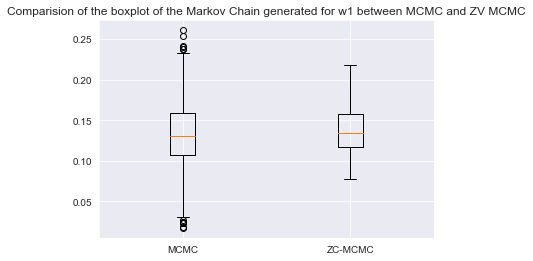

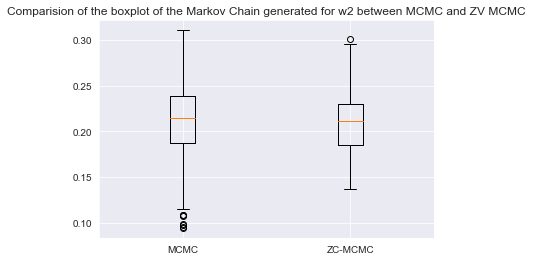

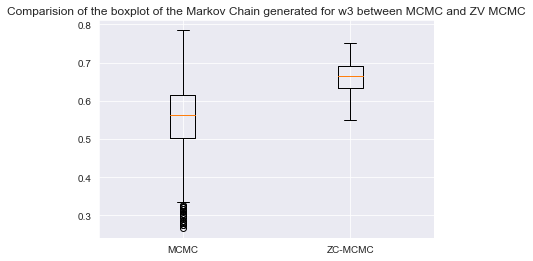

In [ ]:
boxplot_comparision(w1_tilde, w1[burn_in:],'w1')
boxplot_comparision( w2_tilde, w2[burn_in:], 'w2')
boxplot_comparision(w3_tilde,w3[burn_in:], 'w3')

**Comparison with the naive method**

**We could compare this LASSO method with the naive method which only consists in doing the full regression of $f$ on $-z$ in order to find the optimal coefficients $a$ (9 components in the vector $a$ for the 2nd order polynomial case insteadof 3 in Question 2 with 1st order polynomial case.**

**It should lead to a lower variance but a longer time for the execution of the algorithm, which is why we would prefer use the LASSO Method when we have a high degre polynomial case.**

In [ ]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 5000
burn_in = 1000

std_prior = 10
std_proposal = 0.01

In [ ]:
# We run the basic Metropolis Sampler
liste = metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)

# We store the values of w1, w2 and w3 
w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]

# We create a vector omega 
w = np.column_stack((w1, w2, w3))

# We compute the gradient for each w = [w1,w2,w3] generated in the Chain thanks to our gradient function
x = [gradient(_post, np.asarray(omega)) for omega in w]

# We store the gradients and we multiply by 0.5 like in the formula of the article
x1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in x]
x1 = [0.5*x for x in x1]

x2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in x]
x2 = [0.5*x for x in x2]

x3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in x]
x3 = [0.5*x for x in x3]

# We construct the 6 other control variates thanks to the function list_product
x1x2 = list_product(x1,x2)
x1x3 = list_product(x1,x3)
x2x3 = list_product(x2,x3)
x1_square = list_product(x1,x1)
x2_square = list_product(x2,x2)
x3_square = list_product(x3,x3)

# We store these 9 control variates in an array 
z = np.column_stack((x1, x2, x3, x1x2, x2x3, x1x3, x1_square, x2_square, x3_square))

# We store our data in arrays after burn in 
Y = np.array(w[burn_in:])
Z = np.array(z[burn_in:])

In [ ]:
# We also store 
Y1 = np.array(w1[burn_in:])
Y2 = np.array(w2[burn_in:])
Y3 = np.array(w3[burn_in:])

In [ ]:
# We do the 3 regressions of w_1, w_2 and w_3 on Z : step 4 of the method 

def OLS_bis(w1, w2, w3):
    reg1 = LinearRegression()
    reg1.fit(Z, w1)
    coeff_reg1 = reg1.coef_.tolist()
    reg2 = LinearRegression()
    reg2.fit(Z, w2)
    coeff_reg2 = reg2.coef_.tolist()
    reg3 = LinearRegression()
    reg3.fit(Z, w3)
    coeff_reg3 = reg3.coef_.tolist()
    # We return the coefficient of the 3 regressions
    return coeff_reg1, coeff_reg2, coeff_reg3

In [ ]:
# We compute the a vector as well as the B matrix defined in the article and previously in the notebook

def coefficients_finaux_bis(w1, w2, w3):
    coeff_reg1 = OLS_bis(w1, w2, w3)[0]
    coeff_reg2 = OLS_bis(w1, w2, w3)[1]
    coeff_reg3 = OLS_bis(w1, w2, w3)[2]
        
    #This corresponds, for each wi, to the 3 first coefficients of the control variates associated to each linear regression
    a_reg1 = [coeff_reg1[i] for i in range(3)]
    a_reg2 = [coeff_reg2[i] for i in range(3)]
    a_reg3 = [coeff_reg3[i] for i in range(3)]
    
    # B is symmetric so we only need 6 coefficients for the 6 remaining coefficients of the control variates, for each of the 3 regression
    # First regression 
    reg1_b11 = coeff_reg1[6]
    reg1_b12 = coeff_reg1[3]
    reg1_b13 = coeff_reg1[5]
    reg1_b22 = coeff_reg1[7]
    reg1_b23 = coeff_reg1[4]
    reg1_b33 = coeff_reg1[8]
    B_reg1 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    # Second regression 
    reg2_b11 = coeff_reg2[6]
    reg2_b12 = coeff_reg2[3]
    reg2_b13 = coeff_reg2[5]
    reg2_b22 = coeff_reg2[7]
    reg2_b23 = coeff_reg2[4]
    reg2_b33 = coeff_reg2[8]
    B_reg2 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    # Third regression 
    reg3_b11 = coeff_reg3[6]
    reg3_b12 = coeff_reg3[3]
    reg3_b13 = coeff_reg3[5]
    reg3_b22 = coeff_reg3[7]
    reg3_b23 = coeff_reg3[4]
    reg3_b33 = coeff_reg3[8]
    B_reg3 = np.array([[reg1_b11,reg1_b12,reg1_b13],[reg1_b12,reg1_b22,reg1_b23],[reg1_b13,reg1_b23,reg1_b33]])
    
    return a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3

In [ ]:
# Function to compute the trace of the 3 B matrices 
def trace(B):
    return(B[0,0] + B[1,1] + B[2,2])

In [ ]:
# We can finally create the f tilde(w_i) thanks to the formula above and presented in the article

def ZV_MCMC_Q3_bis(w1, w2, w3):
    a_reg1, B_reg1, a_reg2, B_reg2, a_reg3, B_reg3 = coefficients_finaux_bis(w1, w2, w3)
    trace_reg1, trace_reg2, trace_reg3 = trace(B_reg1), trace(B_reg2), trace(B_reg3)
    w1_tilde = [w1[i] - (0.5)*trace_reg1 + np.dot(a_reg1 + np.dot(B_reg1,Y[i]), x[i]) for i in range(len(Y1))]
    w2_tilde = [w2[i] - (0.5)*trace_reg2 + np.dot(a_reg2 + np.dot(B_reg2,Y[i]), x[i]) for i in range(len(Y2))]
    w3_tilde = [w3[i] - (0.5)*trace_reg3 + np.dot(a_reg3 + np.dot(B_reg3,Y[i]), x[i]) for i in range(len(Y3))]
    return w1_tilde, w2_tilde, w3_tilde

In [ ]:
w1_tilde, w2_tilde, w3_tilde = ZV_MCMC_Q3_bis(Y1, Y2, Y3)

print("Mean of w_1 for the ZV MCMC method with control variates =", np.mean(w1_tilde))
print("Mean of w_1 for the MCMC method without control variates =", np.mean(w1[:burn_in]))
print("Variance of w_1 for the ZV MCMC method with control variates =", np.var(w1_tilde))
print("Variance of w_1 for the MCMC method without control variates =", np.var(w1[:burn_in]))

print("Mean of w_2 for the ZV MCMC method with control variates =", np.mean(w2_tilde))
print("Mean of w_2 for the MCMC method without control variates =", np.mean(w2[:burn_in]))
print("Variance of w_2 for the ZV MCMC method with control variates =", np.var(w2_tilde))
print("Variance of w_2 for the MCMC method with control variates =", np.var(w2[:burn_in]))

print("Mean of w_3 for the ZV MCMC method with control variates =", np.mean(w3_tilde))
print("Mean of w_3 for the MCMC method with control variates =", np.mean(w3[:burn_in]))
print("Variance of w_3 for the ZV MCMC method with control variates =", np.var(w3_tilde))
print("Variance of w_3 for the MCMC method with control variates =", np.var(w3[:burn_in]))

Mean of w_1 for the ZV MCMC method with control variates = 0.10952524731856504
Mean of w_1 for the MCMC method without control variates = 0.12288437586873033
Variance of w_1 for the ZV MCMC method with control variates = 0.004068829516251412
Variance of w_1 for the MCMC method without control variates = 0.003749180956130834
Mean of w_2 for the ZV MCMC method with control variates = 0.2085060841208653
Mean of w_2 for the MCMC method without control variates = 0.20634928563897542
Variance of w_2 for the ZV MCMC method with control variates = 0.008135632333465915
Variance of w_2 for the MCMC method with control variates = 0.0017832146880405223
Mean of w_3 for the ZV MCMC method with control variates = 0.675598835455312
Mean of w_3 for the MCMC method with control variates = 0.6608928884265733
Variance of w_3 for the ZV MCMC method with control variates = 0.015382777987012748
Variance of w_3 for the MCMC method with control variates = 0.010202029308063713


### **IV)** Validity of linear regressions when applied to a MCMC sample and ways to adress this issue *(Bonus question)*

A linear regression can be applied if the following conditions are met:

-	The observations are measured without error
-	There are more observations than explanatory variables
-	The explanatory variables are not collinear
-	**Independence: The observations are independent and identically distributed (iid)**
-	Homoscedasticity: The variance of the dependent variable must be constant for all values of the independent variable. In other words, the dispersion of the residuals (the difference between the observed and predicted values) must be constant across the entire range of the independent variable.
-	Normality: The residuals must be normally distributed.

The validity of linear regression in the context of MCMC samples depends on the degree of dependence between successive samples. If the samples are strongly dependent, it means that successive sample values are very similar to each other. In this case, linear regression may not be a valid approach to estimate the optimal coefficient a that minimizes the variance of our estimator, as it assumes that the samples are independent and identically distributed (i.i.d.). If this assumption is not met, then linear regression may lead to biased estimates (and underestimated standard errors) of the coefficient a. **Therefore, the fact that we do linear regression is not completely valid when applied to a MCMC sample since, with our Metropolis Sampler, we create a Markov Chain where every step of the chain depends on the step just before. Thus, the independence condition of linear regressions is not fully met.**  

In other words, if the samples are strongly dependent, this can introduce autocorrelation in the sample that must be taken into account when estimating the coefficient a. **More sophisticated techniques such as time series analysis or spectral analysis can help model this autocorrelation and estimate the coefficient a more accurately. Also, some other methods like subsampling and or averaging over blocks of a given size could be used to make MCMC simulations less “dependent”.**

**1st method: Subsampling:**

Subsampling is a method that involves reducing the size of the observation sample by selecting only a subset of the data. This technique can be used to reduce the dependence between observations and facilitate the use of linear regression. The principle is to select a random sample of observations from the original dataset to construct a reduced-size design submatrix. This allows for the reduction of the dataset size while preserving certain important characteristics, such as descriptive statistics of the dataset.
Thus, subsampling is an effective approach for linear regression even when there is dependence in the observed data because it allows us to use a small proportion of the data as a surrogate for the full sample. This method is described in the article *Optimal Subsampling Approaches for Large Sample Linear Regression (Rong Zhu, Ping Ma, Michael W. Mahoney, Bin Yu)*. This paper, explores the power of subsampling as an effective approach for analyzing large sample data.


**2nd method : time series analysis**

Time series analysis can be used to model the dependency structure in the MCMC sample and reduce its dependence. One approach is to use autoregressive models, which assume that each observation in the sample is linearly dependent on one or more of the preceding observations. Autoregressive models can be used to estimate the parameters of the underlying process that generated the sample and to generate new, independent samples from this process. 

**Code of the subsampling method**

We could use, for instance in the first order polynomial case of question 2, the subsampling method in order to make the MCMC samples "less dependent". 

We are going to use the number of subsampling described in the 2nd paper $N = 15\times\sqrt{n}$ where n is the length of the Markov Chain created with the Metropolis algorithm. We therefore use again the code of question 2 but we add the subsampling part. 

In [ ]:
# Subsampling : we use the 15*np.sqrt(N) number of subsamples
#as detailed in the 2nd paper with the LSLASSO(X) Method. 

iterations = 2000
N = np.sqrt(iterations)*15 
length_subsample = int(N)

indices = random.sample(range(1, iterations), length_subsample)
indices = sorted(indices)

In [ ]:
def w_tilde():

    # We run the basic Metropolis Sampler
    liste = metropolis_hastings(initial_omega, returns, iterations,std_prior, std_proposal)
    
    # Chain of w_i
    # We store the values of w1, w2 and w3 
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[0]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[0]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[0]]
    # We create a vector omega 
    
    w1_subsampled = [w1[i] for i in indices]
    w2_subsampled = [w2[i] for i in indices]
    w3_subsampled = [w3[i] for i in indices]
    
    w = np.column_stack((w1_subsampled, w2_subsampled, w3_subsampled))

    # Computation of the z_i
    # We compute the gradient for each w = [w1,w2,w3] generated in the Chain thanks to our gradient function
    x = [gradient(_post, np.asarray(omega)) for omega in w]
    # We store the gradients and we multiply by 0.5 since the control variates are
    x1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in x]
    x1 = [0.5*x for x in x1]
    x2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in x]
    x2 = [0.5*x for x in x2]
    x3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in x]
    x3 = [0.5*x for x in x3]
    # We store these 3 control variates in an array 
    z = np.column_stack((x1, x2, x3))

    # We store our data in arrays afetr burn in 
    Y = np.array(w)
    Z = np.array(z)

    # We create a linear regression object 
    regression = LinearRegression()

    # We train the model 
    regression.fit(Z, Y)

    # We store the optimal coefficients of the 3 regression 
    a = regression.coef_

    # Imprimer les coefficients de régression
    print("Coefficients de a de la régression de w sur les control variates: ", a)

    # We store the optimal coefficients as lists
    coeffs_w1 = a.tolist()

    # We compute a transposed times Z and we add a -1 since we do in fact the regression of W on -Z. 
    aTz = np.dot(a,(-Z).T)

    trans = aTz.T

    trans_w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in trans]
    trans_w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in trans]
    trans_w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in trans]

    return w1_subsampled, trans_w1, w2_subsampled, trans_w2, w3_subsampled, trans_w3

In [ ]:
# Initialization of the parameters and creation of a list of returns on simulated data
initial_omega = [0.3,0.3,0.3]

returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 2000
burn_in = 1000
std_prior = 10
std_proposal = 0.01

In [ ]:
w_tilde = w_tilde()

Coefficients de a de la régression de w sur les control variates:  [[-0.00184612 -0.00120366  0.00309614]
 [-0.00100479 -0.0033311   0.00349026]
 [ 0.00283514  0.00363649 -0.00632371]]


In [ ]:
# Results for w1
def w1_results(w_tilde):
    w1 = w_tilde[0]
    transw1 = w_tilde[1]
    w1_tilde = sum_list(w1, transw1)
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

Expected value of w1 = 0.12791405820039353
Expected value of w1_tilde = 0.10891620825301286
Variance of w1 = 0.001884779488105232
Variance of w1_tilde = 0.0005178762685751082


In [ ]:
# Results for w2
def w2_results(w):
    w2 = w_tilde[2]
    transw2 = w_tilde[3]
    w2_tilde = sum_list(w2, transw2)
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

print("Expected value of w2 =", w2_results(w_tilde)[0])
print("Expected value of w2_tilde =", w2_results(w_tilde)[1])
print("Variance of w2 =", w2_results(w_tilde)[2])
print("Variance of w2_tilde =", w2_results(w_tilde)[3])

Expected value of w2 = 0.23579018729489176
Expected value of w2_tilde = 0.21505850487511036
Variance of w2 = 0.0023295655763567857
Variance of w2_tilde = 0.0003216894504733031


In [ ]:
# Results for 
def w3_results(w):
    w3 = w_tilde[4]
    transw3 = w_tilde[5]
    w3_tilde = sum_list(w3, transw3)
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

print("Expected value of w3 =", w3_results(w_tilde)[0])
print("Expected value of w3_tilde =", w3_results(w_tilde)[1])
print("Variance of w1 =", w3_results(w_tilde)[2])
print("Variance of w1_tilde =", w3_results(w_tilde)[3]) 

Expected value of w3 = 0.6413887775952101
Expected value of w3_tilde = 0.6776979906859422
Variance of w1 = 0.005560746594432555
Variance of w1_tilde = 0.0009954360651237835


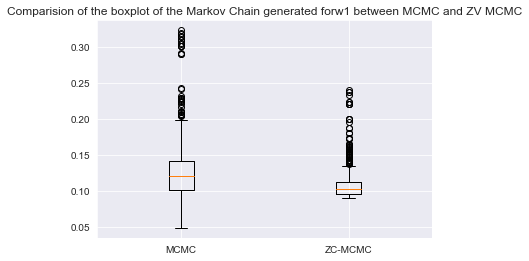

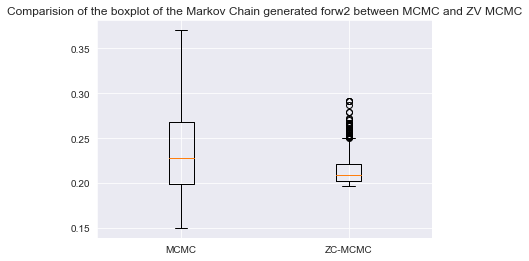

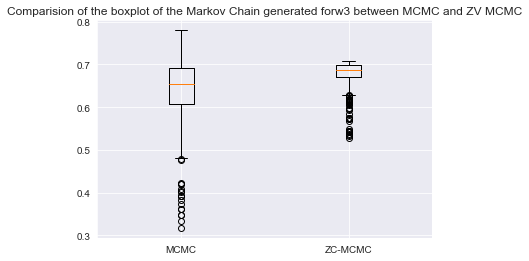

In [ ]:
boxplot_comparision(w_tilde[0], w1_results(w_tilde)[4], 'w1')
boxplot_comparision(w_tilde[2], w2_results(w_tilde)[4], 'w2')
boxplot_comparision(w_tilde[4], w3_results(w_tilde)[4], 'w3')

**We can see that the subsampling technique is effective since we have a better estimator than for question 2 thanks to the subsampling which has allowed to make the linear regression approach more valid.**

### Conclusion 

To conclude this project, we saw that Monte Carlo Markov Chain can be used in order to estimate the posterior distribution of some parameters with a Metropolis Hastings algorithm for instance. By adding control variates, we can **in theory** reduce the variance of the estimators of the parameters. 

Indeed, linear regression OLS or LASSO methods can be used to determine the optimal coefficients of the control variates in the regression of $f$ on $-z$ and then the function $\tilde{f}$ allows to have the same expected value but with a reduction of variance: that is why it is called the Zero Variance (ZV) MCMC estimator. 

However, in our Garch Bayesian model for instance, we saw that, **in practice**, it is hard to compute some values due to the limits of Python when dealing with huge or very low values as well as log and exp. Moreover, we tried to apply linear regressions to find coefficient which is not totally valid due to the dependence of the samples generated by Metropolis algorithm. 

### Sources 

**2 main articles:** 
- *Zero Variance Markov Chain Monte Carlo for Bayesian Estimators* (Antonietta Mira · Reza Solgi · Daniele Imparato)
- *Control variate selection for Monte Carlo integration* (Rémi Leluc, François Portier, Johan Segers)

**Other articles and websites for the writting of the notebook:**
- *Zero-variance principle for Monte Carlo algorithms* (Roland Assaraf and Michel Caffarel)
- *Optimal Subsampling Approaches for Large Sample Linear Regression* (Rong Zhu, Ping Ma, Michael W. Mahoney, Bin Yu)
- Simulation and Monte Carlo slides, Nicolas Chopin 
- Introduction aux processus stochastiques Notes de cours, Nicolas Chopin
- https://en.wikipedia.org/wiki/Lasso_(statistics)
- https://fr.wikipedia.org/wiki/Algorithme_de_Metropolis-Hastings
- https://fr.wikipedia.org/wiki/Loi_tronquée
- https://en.wikipedia.org/wiki/Markov_chain
- https://en.wikipedia.org/wiki/Bayesian_statistics
- https://fr.wikipedia.org/wiki/Modèles_ARCH